In [1]:
# the building we want to run
building_id = 3
# Price of the panel
price = 106
# this will create a folder which will save the files
iteration = 40
# optimization method
# Currently implemented are: rbf-net, rbf-cost, ga-50, ga-20
opt_method = "rbf-cost"
# Number of evaluations:
number_of_opt_evaluations = 100
# number of run
run_i=2
# Some cluster solution
base_path=""

In [2]:
# Parameters
opt_method = "rbf-cost"
number_of_opt_evaluations = 200
run_i = 3
iteration = 71
building_id = 2
price = 106


In [3]:
# Important file names 
# This is where the optimal solution or final population of solutions is provided
ga_file = f"{number_of_opt_evaluations}_{price}_{opt_method}_{building_id}_{run_i}.xlsx"
# here we store every run that optmizer runs
ga_proc = f"{number_of_opt_evaluations}_archived_{price}_{opt_method}_{building_id}_{run_i}.xlsx"
# Here we combine the optimal solution with the addition information that we are interested in.
ga_fina = f"{number_of_opt_evaluations}_processed_{price}_{opt_method}_{building_id}_{run_i}.xlsx"

In [4]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [5]:
########### OUTPUT FILES ###############
import os
import time
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    try:
      if not os.path.exists(directory):
          os.makedirs(directory)
    except:
      time.sleep(10)
      if not os.path.exists(directory):
          os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [8]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [9]:
pvbuilding.North_Axis

0.0

In [10]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [11]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/


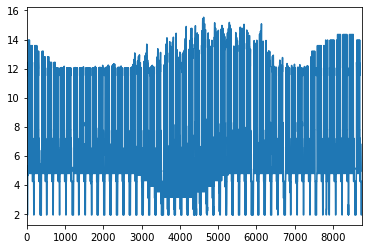

In [12]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [13]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.56
14.35221199000051


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [14]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

energy_plus/output_energy_plus/rbf-cost-106-2-3/eplusout.sql
Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [15]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4162731170654297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.939910888671875 sec


ERROR:root:Finished Generation of Irradiance


0.0


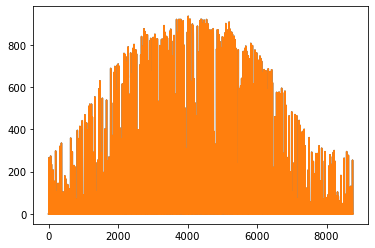

In [16]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,845 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.56


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


{'name': 'gurobi', 'options': None}
Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3328969478607178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.368574380874634 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.400195837020874 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


INFO:root:Constraint: calc_investment_cost


INFO:root:Constraint: calc_maintenance_cost


INFO:root:Constraint: calc_operating_cost


INFO:root:Constraint: calc_total_carbon


INFO:root:Constraint: calc_total_cost


INFO:root:Constraint: constrain_max_energy


INFO:root:Constraint: daily_c_lower_medlar


INFO:root:Constraint: daily_c_lower_small


INFO:root:Constraint: daily_c_upper_medlar


INFO:root:Constraint: daily_c_upper_small


INFO:root:Constraint: energy_balance


INFO:root:Constraint: force_install


INFO:root:Constraint: large_lower


INFO:root:Constraint: large_operating_export_lower


INFO:root:Constraint: large_operating_export_upper


INFO:root:Constraint: large_operating_import_lower


INFO:root:Constraint: large_operating_import_upper


INFO:root:Constraint: large_upper


INFO:root:Constraint: max_carbon_level


INFO:root:Constraint: max_track_constraint


INFO:root:Constraint: med_operating_export_lower


INFO:root:Constraint: med_operating_export_upper


INFO:root:Constraint: med_operating_import_lower


INFO:root:Constraint: med_operating_import_upper


INFO:root:Constraint: medium_lower


INFO:root:Constraint: medium_upper


INFO:root:Constraint: monthly_bill_lower


INFO:root:Constraint: monthly_bill_upper


INFO:root:Constraint: monthly_export_constraint


INFO:root:Constraint: monthly_import_constraint


INFO:root:Constraint: net_metering_constraint


INFO:root:Constraint: roof_tech_area_below_max


INFO:root:Constraint: roof_tech_area_definition


INFO:root:Constraint: roof_tech_cap_max


INFO:root:Constraint: small_demand_charge_constraint


INFO:root:Constraint: small_operating_export_lower


INFO:root:Constraint: small_operating_export_upper


INFO:root:Constraint: small_operating_import_lower


INFO:root:Constraint: small_operating_import_upper


INFO:root:Constraint: storage_balance


INFO:root:Constraint: storage_charge_rate


INFO:root:Constraint: storage_discharge_rate


INFO:root:Constraint: storage_input_positive


INFO:root:Constraint: storage_is_installed


INFO:root:Constraint: storage_is_installed_2


INFO:root:Constraint: storage_level_above_minimum


INFO:root:Constraint: storage_level_below_capacity


INFO:root:Constraint: storage_level_positive


INFO:root:Constraint: storage_looping


INFO:root:Constraint: storage_output_positive


INFO:root:Constraint: tech_export_positive


INFO:root:Constraint: tech_import_positive


INFO:root:Constraint: tech_input_below_capacity


INFO:root:Constraint: tech_input_positive


INFO:root:Constraint: tech_is_installed


INFO:root:Constraint: tech_is_installed_2


INFO:root:Constraint: tech_is_on


INFO:root:Constraint: tech_is_on_2


INFO:root:Constraint: tech_part_loads


INFO:root:Constraint: total_export_value_constraint


INFO:root:Constraint: total_import_value_constraint


INFO:root:Constraint: total_roof_area_definition


INFO:root:Constraint: track_above_150_constraint_lower


INFO:root:Constraint: track_above_150_constraint_upper


INFO:root:Constraint: track_above_35_constraint_lower


INFO:root:Constraint: track_above_35_constraint_upper


INFO:root:Constraint: track_above_550_constraint_lower


INFO:root:Constraint: track_above_550_constraint_upper


INFO:root:Constraint: track_any_above_150_constraint_lower


INFO:root:Constraint: track_any_above_150_constraint_upper


INFO:root:Constraint: track_any_above_35_constraint_lower


INFO:root:Constraint: track_any_above_35_constraint_upper


INFO:root:Constraint: track_or_constraint_lower


INFO:root:Constraint: track_or_constraint_upper


INFO:root:Constraint: track_or_constraint_upper2


INFO:root:Constraint List: capacity_bounds


ERROR:ga_logger:Recompiled the model in 207 s


ERROR:ga_logger:Starting solver


None


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [307.53518498812736, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.5574048188814


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


Total Electricity Imported from the grid 50,271 kWh
At a cost of $ 0.1253 /kWh
Total Cost of the system: $ 3,188 per year


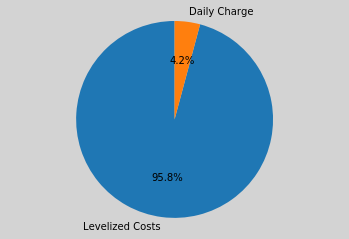

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%


In [17]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings={
                    'name': 'gurobi',
                    'options':None
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=1.5,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
my_model.energyIm

50270.728631185906

In [19]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [20]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr     3953.588272
Aug     4232.535574
Dec     4728.407874
Feb     4220.904101
Jan     4695.625513
Jul     3596.797122
Jun     3505.544383
Mar     4553.295110
May     3930.927926
Nov     4284.410932
Oct     4521.675077
Sep     4047.016748
monthly_import    50270.728631
dtype: float64
50270.728631185906
     monthly_export
Apr     6047.180913
Aug     6614.423308
Dec      804.969294
Feb     2251.160819
Jan      895.761370
Jul     7708.016021
Jun     6371.405780
Mar     3649.482470
May     7091.115573
Nov      925.105855
Oct     2596.898286
Sep     5315.108943
monthly_export    50270.628631
dtype: float64
50270.62863118734
133.0424999999616


In [21]:
my_model.solveResults['solution']['daily_charge_c']

133.0424999999616

In [22]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng           1.0
Grid               1.0
Invertor           1.0
PV0                1.0
PV1                0.0
PV2                0.0

In [23]:
my_model.solveResults['solution']['any_above_35']

0.0

In [24]:
my_model.solveResults['solution']['a150_or_a550']

0.0

# (D) GA - Optimize the model

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [27]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings,
                         force_install=False)



ERROR:optimizer_logger:Found the solver set


/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:The number of evaluations is 200


[90.  90.  90.   1.   1.   1.   0.2  0.2  0.2] [265.  265.  265.   56.   56.   56.    0.9   0.9   0.9] ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R']


ERROR:ga_logger:panel values: (224.84135479642626, 259.91019525424923, 261.13473369607874, 24.89730931121749, 39.7291425922611, 23.359526359034795, 0.2840448854534836, 0.6045887058405985, 0.38570147128013943)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 24.9
                                           and a gcr of 0.284


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.566258192062378 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 39.7
                                           and a gcr of 0.605


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4269046783447266 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 23.4
                                           and a gcr of 0.386


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.455704689025879 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 200 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 362.00454993098674, 0.0]


ERROR:ga_logger:Cost: 4273.423284588775


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (166.82512639942837, 108.77149490308749, 228.487496983594, 7.368488344194907, 31.36690753643775, 13.629455325041649, 0.6436930712436162, 0.70774747563352, 0.5726928351610476)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 7.4
                                           and a gcr of 0.644


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4266414642333984 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 109
                                           a tilt of 31.4
                                           and a gcr of 0.708


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4630627632141113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 228
                                           a tilt of 13.6
                                           and a gcr of 0.573


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8432250022888184 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 197 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [318.03677441927204, 0.0, 0.0]


ERROR:ga_logger:Cost: 3291.861274090801


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


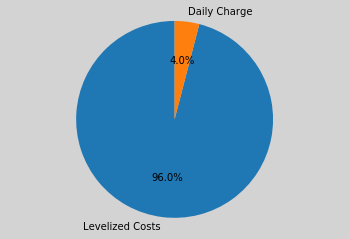

ERROR:ga_logger:panel values: (258.093110884055, 178.75897552778736, 142.26008614903202, 53.02460455215793, 20.117997476198397, 1.0763586348253384, 0.8703827628895435, 0.8941211590286116, 0.800166488406)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 258
                                           a tilt of 53.0
                                           and a gcr of 0.870


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4564735889434814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 20.1
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4552948474884033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 142
                                           a tilt of 1.1
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5463407039642334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 199 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 318.60706619634294, 0.0]


ERROR:ga_logger:Cost: 3297.5255419028417


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (150.02886091692042, 135.16959942932, 109.76742288433431, 42.89098567282696, 45.677148026521465, 52.73082320072545, 0.47500657403289687, 0.4617642763317002, 0.27898993851085063)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 42.9
                                           and a gcr of 0.475


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.630683660507202 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 45.7
                                           and a gcr of 0.462


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5825071334838867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 52.7
                                           and a gcr of 0.279


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.733513355255127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 203 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [284.4157348395004, 0.0, 0.0]


ERROR:ga_logger:Cost: 3612.624632511151


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


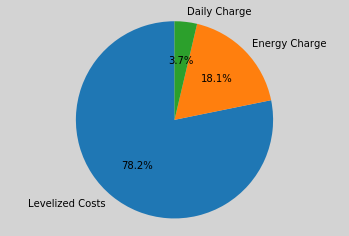

ERROR:ga_logger:panel values: (101.49259475145308, 222.38353038344604, 194.01885801238097, 15.126033926969361, 11.945761278772528, 42.36770763414162, 0.542545668998069, 0.23752194235172797, 0.666784848773743)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 101
                                           a tilt of 15.1
                                           and a gcr of 0.543


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.711728572845459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 222
                                           a tilt of 11.9
                                           and a gcr of 0.238


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.728680372238159 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 194
                                           a tilt of 42.4
                                           and a gcr of 0.667


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6023168563842773 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 204 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 313.15319660951695]


ERROR:ga_logger:Cost: 3243.356634849817


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


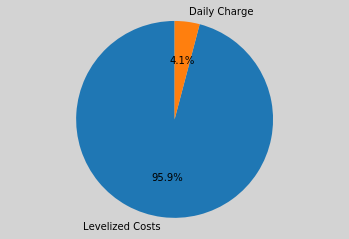

ERROR:ga_logger:panel values: (177.5, 177.5, 177.5, 28.5, 28.5, 28.5, 0.5499999999999999, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7133357524871826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.609504461288452 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.573603868484497 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 200 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.16115923082754]


ERROR:ga_logger:Cost: 3084.5205097866624


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


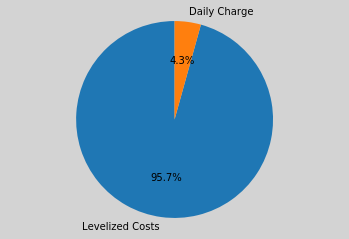

ERROR:ga_logger:panel values: (264.23144530633397, 90.50435115842097, 91.31835708204122, 1.1234945493227801, 1.2261440218782917, 54.97716459539327, 0.20516091151487087, 0.21265858258756543, 0.8954868953753159)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.1
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.271658182144165 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 91
                                           a tilt of 1.2
                                           and a gcr of 0.213


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.198943614959717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 55.0
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5439257621765137 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 195 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 0.18639926685786787, 535.3983277594848]


ERROR:ga_logger:Cost: 5452.591067753368


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


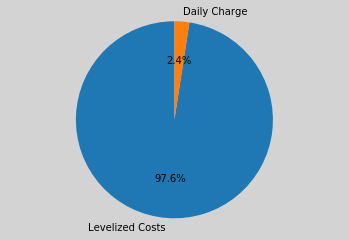

ERROR:ga_logger:panel values: (92.02020794205303, 262.7549950058732, 91.43232719273416, 54.82306785325737, 55.929686016794356, 1.8500872657126841, 0.20228415110746745, 0.20735436375695376, 0.8865862814013268)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 54.8
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7324423789978027 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 55.9
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7493820190429688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 1.9
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5461997985839844 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 181 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 335.9128131456064]


ERROR:ga_logger:Cost: 3469.409658040008


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


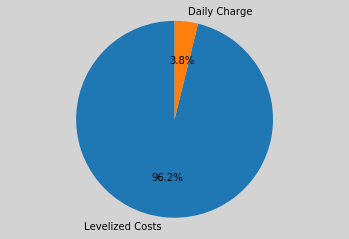

ERROR:ga_logger:panel values: (99.11075649401636, 264.03203919457394, 93.6030688202434, 1.493487662785062, 1.0547567123305588, 1.3023800179270741, 0.2143242021714497, 0.8908432043547478, 0.20135610165075804)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 99
                                           a tilt of 1.5
                                           and a gcr of 0.214


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4294726848602295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 1.1
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6054019927978516 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 94
                                           a tilt of 1.3
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5373237133026123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 170 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [62.54515234764729, 273.43248964641606, 0.0]


ERROR:ga_logger:Cost: 3470.0535509463384


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


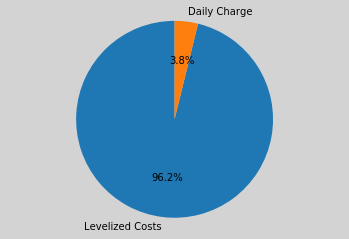

ERROR:ga_logger:panel values: (205.08039803817127, 150.41000207355268, 205.12156111462735, 37.328147604373726, 19.456644215184355, 19.49747578332004, 0.6614480351766872, 0.4347075330824088, 0.4363236329334943)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 37.3
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6112003326416016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 19.5
                                           and a gcr of 0.435


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.557206392288208 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 19.5
                                           and a gcr of 0.436


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8661282062530518 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 177 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [141.1902436583723, 167.4951560561799, 0.0]


ERROR:ga_logger:Cost: 3198.981567660793


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


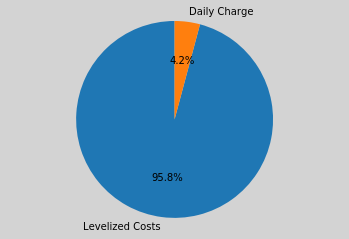

ERROR:ga_logger:panel values: (204.48544458869088, 205.36161092153475, 148.8766430374304, 20.145357946902553, 37.499895173700075, 19.602902063822953, 0.6640510283938411, 0.43475773731932865, 0.43882423873126153)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 204
                                           a tilt of 20.1
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6561825275421143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 37.5
                                           and a gcr of 0.435


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.619047164916992 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 149
                                           a tilt of 19.6
                                           and a gcr of 0.439


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.441682815551758 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 173 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [129.98327334471662, 175.21553386190268, 0.0]


ERROR:ga_logger:Cost: 3164.3520350553513


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


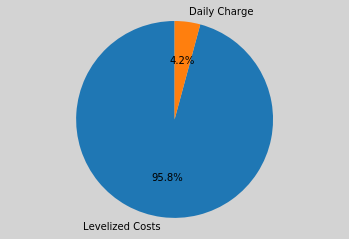

ERROR:ga_logger:panel values: (90.00000000002021, 264.9999999997725, 113.49369971273602, 55.99999999992816, 26.615447054147705, 1.0000000000348601, 0.8999999999999275, 0.8882183785569895, 0.21179187879738956)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.440690517425537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 26.6
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4408998489379883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 113
                                           a tilt of 1.0
                                           and a gcr of 0.212


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4886257648468018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 185 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 349.6140072997759, 43.44889456560201]


ERROR:ga_logger:Cost: 4037.035772215863


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


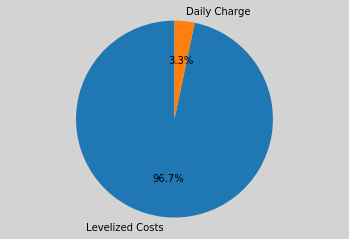

ERROR:ga_logger:panel values: (92.16032299661714, 93.93713261598512, 119.42295808959084, 54.30053346400607, 50.17766124098376, 1.2089560857509682, 0.8927090464122278, 0.22325995506970123, 0.8986576770418326)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 54.3
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4515249729156494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 94
                                           a tilt of 50.2
                                           and a gcr of 0.223


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4329640865325928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 119
                                           a tilt of 1.2
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2031009197235107 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 197 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 334.3062049463194]


ERROR:ga_logger:Cost: 3453.452504448555


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


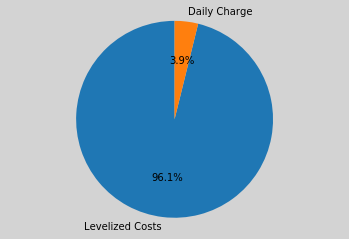

ERROR:ga_logger:panel values: (92.01153622057821, 245.8253348069279, 95.06830718462139, 1.4375270213854532, 3.5035044794121393, 1.468308510327845, 0.8890800311187079, 0.7907930891924855, 0.899466771490522)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 1.4
                                           and a gcr of 0.889


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3209166526794434 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 246
                                           a tilt of 3.5
                                           and a gcr of 0.791


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.38448166847229 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 1.5
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3024699687957764 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 206 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 333.31927520187804, 0.0]


ERROR:ga_logger:Cost: 3443.6501214450973


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (92.47825127266972, 190.3325162904811, 175.46337720874854, 19.74191590199066, 23.668425299112517, 2.3260628171006172, 0.8479308992200523, 0.35811238551748614, 0.7776208199132975)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 19.7
                                           and a gcr of 0.848


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.460376024246216 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 23.7
                                           and a gcr of 0.358


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.470658302307129 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 2.3
                                           and a gcr of 0.778


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4458773136138916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 202 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 128.70019971120777, 186.14433442612233]


ERROR:ga_logger:Cost: 3260.1553082905702


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


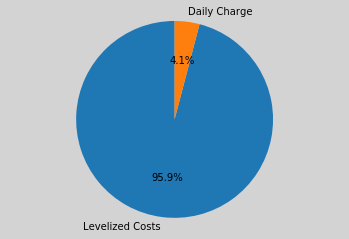

ERROR:ga_logger:panel values: (148.7972438101725, 171.50752343843544, 148.95590470189467, 30.332845070304508, 24.9544449502965, 19.540281841402514, 0.6648114459268243, 0.5409863532035806, 0.654354319467042)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 30.3
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4295907020568848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 172
                                           a tilt of 25.0
                                           and a gcr of 0.541


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4423491954803467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 149
                                           a tilt of 19.5
                                           and a gcr of 0.654


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.458786964416504 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 205 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 298.00390978640485, 0.0]


ERROR:ga_logger:Cost: 3092.8908735162886


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


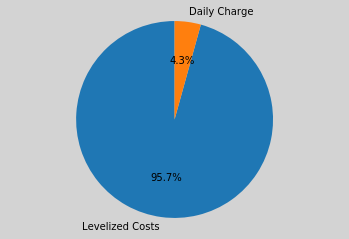

ERROR:ga_logger:panel values: (158.5462587699054, 176.16565980484518, 175.5653043119019, 27.070280110054508, 28.53458537418314, 21.363591913289007, 0.6634870778656318, 0.49608242912479084, 0.5423509002635325)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 159
                                           a tilt of 27.1
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4342403411865234 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 28.5
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5716991424560547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 21.4
                                           and a gcr of 0.542


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.454160213470459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 214 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 295.4322392936103, 0.0]


ERROR:ga_logger:Cost: 3067.348530693345


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


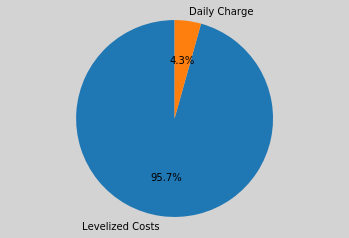

ERROR:ga_logger:panel values: (169.38915032724384, 175.5756620661078, 173.06470516847367, 28.959267156281328, 28.419595007646254, 25.274398282933042, 0.6177398719171489, 0.5389499033608096, 0.554008944182592)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 169
                                           a tilt of 29.0
                                           and a gcr of 0.618


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.46940279006958 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 28.4
                                           and a gcr of 0.539


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.488685131072998 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 25.3
                                           and a gcr of 0.554


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4473443031311035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 210 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 296.89987025354526, 0.0]


ERROR:ga_logger:Cost: 3081.9253351785333


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


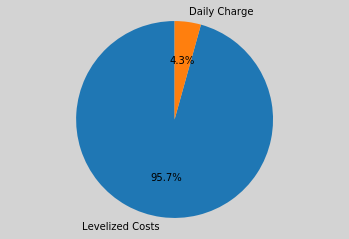

ERROR:ga_logger:panel values: (94.46034585422251, 140.12938246220514, 264.843246778184, 55.321794390300106, 55.3994846627645, 2.479843971096832, 0.899692949553242, 0.8961912360072366, 0.8834792823363713)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 94
                                           a tilt of 55.3
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4091663360595703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 55.4
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.481567859649658 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 2.5
                                           and a gcr of 0.883


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4567477703094482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 211 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.6952770895125]


ERROR:ga_logger:Cost: 3477.181246352392


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


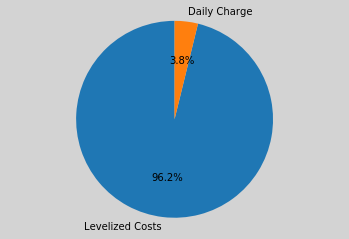

ERROR:ga_logger:panel values: (90.75308829702941, 95.03764828319987, 112.31123619998579, 3.3163420588255255, 53.60124360804396, 2.5208800702412657, 0.8846644869762452, 0.25622706878805557, 0.22920300913019456)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 3.3
                                           and a gcr of 0.885


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.350836753845215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 53.6
                                           and a gcr of 0.256


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4908664226531982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 112
                                           a tilt of 2.5
                                           and a gcr of 0.229


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.291658401489258 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 209 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [268.2170498857602, 0.0, 67.7470524740157]


ERROR:ga_logger:Cost: 3469.919073083496


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


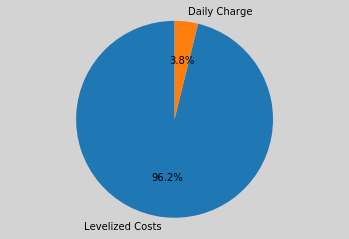

ERROR:ga_logger:panel values: (91.29792225864821, 120.67361508613052, 242.89746942950373, 35.07695700458778, 4.706681830242329, 2.6098337067415533, 0.8949969744906925, 0.6074691229024883, 0.4624658377591583)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 35.1
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.471348762512207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 121
                                           a tilt of 4.7
                                           and a gcr of 0.607


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6025390625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 243
                                           a tilt of 2.6
                                           and a gcr of 0.462


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3754146099090576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 209 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 328.6949371923495, 0.0]


ERROR:ga_logger:Cost: 3397.720273028729


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


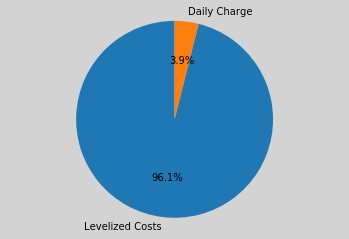

ERROR:ga_logger:panel values: (158.50980947830607, 182.82144791889812, 159.24516021277344, 24.972112485738332, 30.08990434791473, 16.750233668635772, 0.7083097042791089, 0.4684030482471428, 0.5628787623195646)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 159
                                           a tilt of 25.0
                                           and a gcr of 0.708


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5458362102508545 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 30.1
                                           and a gcr of 0.468


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5624279975891113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 159
                                           a tilt of 16.8
                                           and a gcr of 0.563


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5475776195526123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 202 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [46.15744673962547, 249.93801781413447, 0.0]


ERROR:ga_logger:Cost: 3073.9358172627008


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


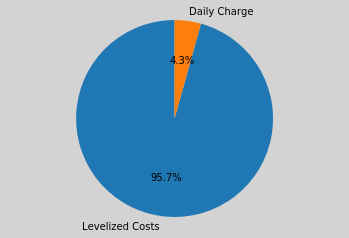

ERROR:ga_logger:panel values: (156.3432185403891, 175.6273955164993, 169.0277835831505, 28.01027872498701, 28.12045760618232, 19.521210287915196, 0.6945527947518856, 0.5086072271832982, 0.5750208232584493)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 28.0
                                           and a gcr of 0.695


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4978187084198 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 28.1
                                           and a gcr of 0.509


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5225160121917725 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 19.5
                                           and a gcr of 0.575


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.49998140335083 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 192 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 295.9019805096008, 0.0]


ERROR:ga_logger:Cost: 3072.0140941537225


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (161.48623713217705, 177.09932747055842, 170.9702131875094, 27.061636817474312, 29.191797124446886, 21.014149591111025, 0.6740351982381318, 0.4938954217180686, 0.5450485387264696)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 161
                                           a tilt of 27.1
                                           and a gcr of 0.674


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5896918773651123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 29.2
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.582630157470703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 171
                                           a tilt of 21.0
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6405513286590576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 295.2619443843925, 0.0]


ERROR:ga_logger:Cost: 3065.6571281266424


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


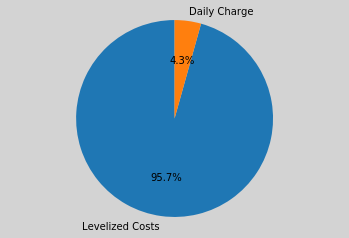

ERROR:ga_logger:panel values: (153.53213392242884, 169.94422615540623, 174.1108116122955, 33.675938654798, 38.93698373063822, 17.204606854787283, 0.621220834868689, 0.4737803764513252, 0.5534522661249638)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 154
                                           a tilt of 33.7
                                           and a gcr of 0.621


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.636026382446289 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 38.9
                                           and a gcr of 0.474


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5993199348449707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 17.2
                                           and a gcr of 0.553


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.644367218017578 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 183 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 186.39759131907326, 113.6434128672925]


ERROR:ga_logger:Cost: 3113.1237060356034


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (163.45510907744176, 160.63500489771207, 171.11063810163637, 23.099454640680722, 30.603299220944265, 21.109291775235903, 0.677762053498244, 0.5055574924821016, 0.5551520214947445)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 163
                                           a tilt of 23.1
                                           and a gcr of 0.678


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6355481147766113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 161
                                           a tilt of 30.6
                                           and a gcr of 0.506


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.535205841064453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 171
                                           a tilt of 21.1
                                           and a gcr of 0.555


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5046536922454834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 186 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 299.0491574061137, 0.0]


ERROR:ga_logger:Cost: 3103.272485190256


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (159.09208218299153, 179.86101155344875, 172.08320028408235, 26.85644909467799, 30.000381825379023, 23.284824027795253, 0.6866421202862876, 0.4785471259874197, 0.5624752013556342)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 159
                                           a tilt of 26.9
                                           and a gcr of 0.687


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5338363647460938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 30.0
                                           and a gcr of 0.479


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5268468856811523 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 23.3
                                           and a gcr of 0.562


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.537179946899414 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 190 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 234.59682439936068, 61.04794621192739]


ERROR:ga_logger:Cost: 3069.459434235029


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (163.94851482301584, 176.33831684505475, 171.77917288902495, 27.60888890764363, 28.40189779600175, 20.83296556266791, 0.6751169039111238, 0.48000300789642886, 0.5470751480213204)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 164
                                           a tilt of 27.6
                                           and a gcr of 0.675


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5789132118225098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 28.4
                                           and a gcr of 0.480


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4903430938720703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 20.8
                                           and a gcr of 0.547


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.535754919052124 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 170 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [29.89206630899306, 266.1543751233044, 0.0]


ERROR:ga_logger:Cost: 3073.4489089289436


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


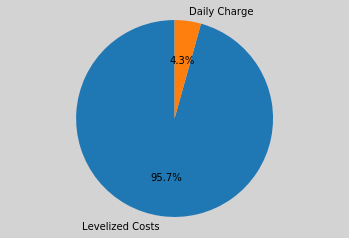

ERROR:ga_logger:panel values: (160.57322492413147, 177.3133891026481, 170.07315476661677, 27.248742582996066, 29.07297808322598, 21.23424794326232, 0.6774536864608875, 0.49540227229920003, 0.5372529328024002)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 161
                                           a tilt of 27.2
                                           and a gcr of 0.677


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.711677074432373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 29.1
                                           and a gcr of 0.495


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6176564693450928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 21.2
                                           and a gcr of 0.537


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6411139965057373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 295.3100569260554, 0.0]


ERROR:ga_logger:Cost: 3066.1349914347766


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


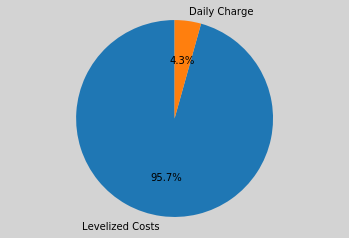

ERROR:ga_logger:panel values: (91.65099621281628, 264.9766349408904, 264.42648383287485, 2.647100606878624, 53.07106595596295, 32.037148002858345, 0.8914478281591447, 0.8977687714414531, 0.8953468952457879)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 2.6
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.495526075363159 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 53.1
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4229660034179688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 32.0
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.630941152572632 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [336.2918626111503, 0.0, 0.0]


ERROR:ga_logger:Cost: 3473.174453271218


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


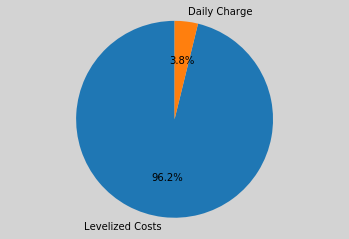

ERROR:ga_logger:panel values: (92.43694095172955, 259.5834514138615, 257.8012021026202, 53.63660016851381, 55.689822690873825, 36.89777601900692, 0.8907301013502031, 0.2331384294143847, 0.8840671857356184)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 53.6
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5483381748199463 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 55.7
                                           and a gcr of 0.233


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.484438180923462 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 258
                                           a tilt of 36.9
                                           and a gcr of 0.884


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4882333278656006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 39.34594745089946, 380.1446649591908]


ERROR:ga_logger:Cost: 4299.521116730383


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


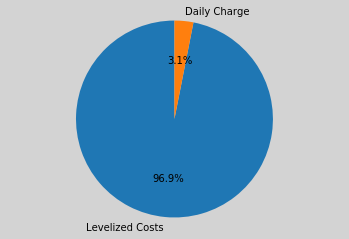

ERROR:ga_logger:panel values: (94.38161812009386, 134.55460452284296, 120.87253907119681, 8.70561854967271, 54.30474980855513, 1.0507821148864196, 0.8826108444408007, 0.8969987014275285, 0.8659796892045253)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 94
                                           a tilt of 8.7
                                           and a gcr of 0.883


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5273966789245605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 54.3
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.425906181335449 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 121
                                           a tilt of 1.1
                                           and a gcr of 0.866


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5081610679626465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 334.399006815798]


ERROR:ga_logger:Cost: 3454.3742311046626


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


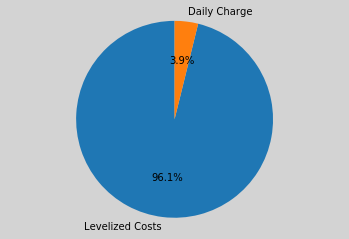

ERROR:ga_logger:panel values: (141.2032531894091, 188.9105612872823, 159.04570206094593, 23.674770162219172, 28.498551391397303, 18.871687263761203, 0.6046770979680467, 0.49948384973399046, 0.5575159390388936)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 141
                                           a tilt of 23.7
                                           and a gcr of 0.605


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6740570068359375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 28.5
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.472804546356201 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 159
                                           a tilt of 18.9
                                           and a gcr of 0.558


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4930977821350098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 295.9235675247652, 0.0]


ERROR:ga_logger:Cost: 3072.2285008616595


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


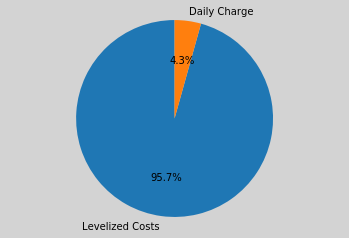

ERROR:ga_logger:panel values: (156.34081988353827, 184.4234206339432, 166.5053627311667, 26.25765855640378, 30.39120877746218, 20.55621290969018, 0.6418948003781543, 0.5016922830894237, 0.5465550175214078)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 26.3
                                           and a gcr of 0.642


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.609096050262451 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 30.4
                                           and a gcr of 0.502


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4395225048065186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 20.6
                                           and a gcr of 0.547


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4506797790527344 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 294.8651333577218, 0.0]


ERROR:ga_logger:Cost: 3061.7159229377517


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


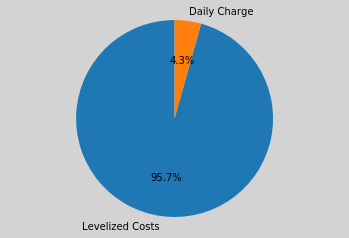

ERROR:ga_logger:panel values: (157.3063815155574, 182.41177293753896, 169.4500923549059, 25.878099534730904, 30.1806133158429, 20.745006871421687, 0.6655166080302104, 0.5010178406503554, 0.5505998213607168)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.9
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6156063079833984 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 30.2
                                           and a gcr of 0.501


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.465928077697754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 20.7
                                           and a gcr of 0.551


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4444334506988525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 294.4868522749042, 0.0]


ERROR:ga_logger:Cost: 3057.958759515062


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (90.19425064743373, 104.37728404921339, 94.19441958635113, 8.839201364594045, 54.34558985154967, 1.1632206418958577, 0.22027759930419644, 0.8818883295310802, 0.20280271515994325)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 8.8
                                           and a gcr of 0.220


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5823559761047363 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 104
                                           a tilt of 54.3
                                           and a gcr of 0.882


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.390716075897217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 94
                                           a tilt of 1.2
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.843646764755249 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [19.271340427507027, 450.88751843185025, 0.0]


ERROR:ga_logger:Cost: 4802.768251194551


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


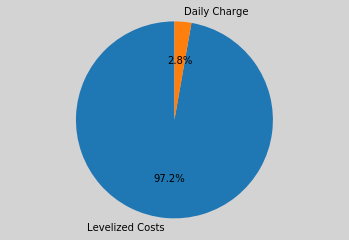

ERROR:ga_logger:panel values: (155.23738521352578, 262.1432624400625, 233.39617235773676, 1.793899533822382, 1.3350353376474797, 1.4242864751185342, 0.8997270003538516, 0.8026330952830389, 0.4200650876026991)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 1.8
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4766957759857178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 1.3
                                           and a gcr of 0.803


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8880558013916016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 233
                                           a tilt of 1.4
                                           and a gcr of 0.420


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0580084323883057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [331.69376978562235, 0.0, 0.0]


ERROR:ga_logger:Cost: 3427.50527684394


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


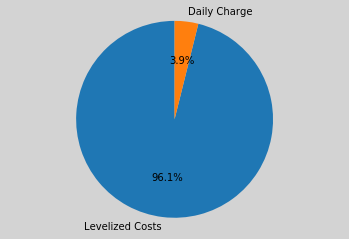

ERROR:ga_logger:panel values: (178.31426869047777, 183.83044089814388, 201.7165261348992, 14.28363065338512, 12.528387082748973, 1.3079875890009958, 0.8937745816424787, 0.7574845810032109, 0.8586312819541044)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 14.3
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.592353343963623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 12.5
                                           and a gcr of 0.757


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6324429512023926 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 202
                                           a tilt of 1.3
                                           and a gcr of 0.859


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1955478191375732 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 311.7052242868969, 0.0]


ERROR:ga_logger:Cost: 3228.9750585237616


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


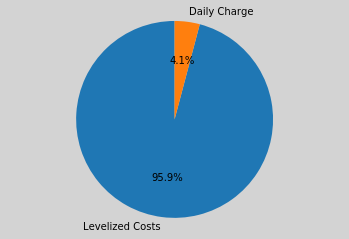

ERROR:ga_logger:panel values: (143.8173778975164, 190.630769630447, 170.32874499986872, 22.25842514891312, 22.273210560366806, 18.64814889482169, 0.7065946729041253, 0.47634326103624364, 0.5816650260756213)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 144
                                           a tilt of 22.3
                                           and a gcr of 0.707


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7054879665374756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 22.3
                                           and a gcr of 0.476


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.463541030883789 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 18.6
                                           and a gcr of 0.582


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.408986806869507 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 221.67642935435845, 77.58858460834817]


ERROR:ga_logger:Cost: 3105.4164088123052


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


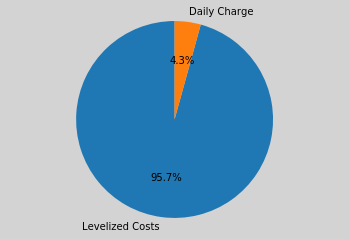

ERROR:ga_logger:panel values: (139.31548812125865, 207.76075178272754, 165.9436716293291, 25.251975758256812, 23.178594399302657, 28.83570616607506, 0.5545654645459652, 0.6040067734804833, 0.6232614386327795)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 25.3
                                           and a gcr of 0.555


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6673049926757812 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 23.2
                                           and a gcr of 0.604


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.463909149169922 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 28.8
                                           and a gcr of 0.623


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.410562515258789 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 149 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 302.4158941171771]


ERROR:ga_logger:Cost: 3136.711587790634


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


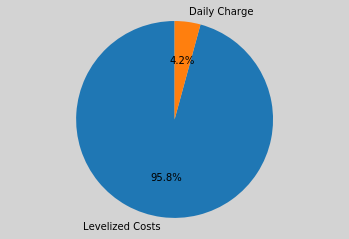

ERROR:ga_logger:panel values: (90.00000000002359, 264.99999999983066, 97.95610745051724, 7.976385031539612, 6.2576143133223665, 14.464157398945902, 0.4846262299500505, 0.20089982200323556, 0.3214190071625042)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 8.0
                                           and a gcr of 0.485


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.602527141571045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 6.3
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.571659564971924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 98
                                           a tilt of 14.5
                                           and a gcr of 0.321


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4053239822387695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [290.1756161882493, 0.0, 0.0]


ERROR:ga_logger:Cost: 4067.2701154131482


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (96.19985365137525, 264.0166716270397, 115.93189373476568, 55.83394838607739, 1.6630800002276804, 1.0384489183502508, 0.20122109982602318, 0.8999271153361443, 0.8959740146453039)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 96
                                           a tilt of 55.8
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.685206174850464 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 1.7
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1495654582977295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 116
                                           a tilt of 1.0
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.454730987548828 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 164 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 334.6871077183932]


ERROR:ga_logger:Cost: 3457.2357068198207


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


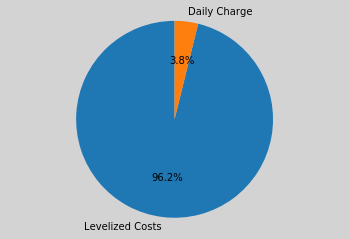

ERROR:ga_logger:panel values: (91.87748041614128, 160.65750976155732, 252.12247937825745, 2.1072793376901906, 4.728706815180987, 53.927656099677506, 0.8735640896561476, 0.8124940976648511, 0.23905779078758063)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 2.1
                                           and a gcr of 0.874


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5433754920959473 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 161
                                           a tilt of 4.7
                                           and a gcr of 0.812


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.382479667663574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 252
                                           a tilt of 53.9
                                           and a gcr of 0.239


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.408242702484131 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 170 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 324.8904828244435, 0.0]


ERROR:ga_logger:Cost: 3359.9336735746383


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (92.42975247616768, 153.76212711787252, 260.29026362889147, 4.8772101173818045, 5.715515128106663, 39.28633530288255, 0.7267552737590761, 0.8751428032637492, 0.8939783988317618)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 4.9
                                           and a gcr of 0.727


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7295477390289307 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 5.7
                                           and a gcr of 0.875


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6167125701904297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 39.3
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.442549705505371 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 325.59991302774387, 0.0]


ERROR:ga_logger:Cost: 3366.9798771532796


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


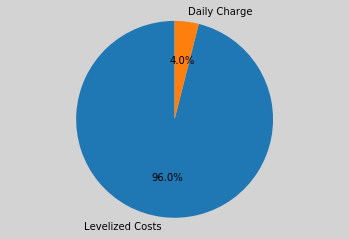

ERROR:ga_logger:panel values: (156.7588205827076, 190.2959788485141, 164.92888867709976, 25.26869641422158, 33.513332575934584, 12.240115016542644, 0.6927880767274882, 0.5899238128381457, 0.6516290700548022)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.3
                                           and a gcr of 0.693


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6686134338378906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 33.5
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3765647411346436 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 12.2
                                           and a gcr of 0.652


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.37493896484375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 300.2096120194567, 0.0]


ERROR:ga_logger:Cost: 3114.798356935652


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (156.62446983833578, 185.1454671123992, 171.24212448694482, 23.899213923251867, 30.474407435812374, 20.430620487294494, 0.6670780065978612, 0.4923747545148708, 0.5495554609716844)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 23.9
                                           and a gcr of 0.667


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6830453872680664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 30.5
                                           and a gcr of 0.492


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4144012928009033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 171
                                           a tilt of 20.4
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4170172214508057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 294.75834359441615, 0.0]


ERROR:ga_logger:Cost: 3060.655265557683


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


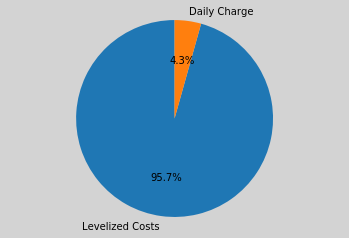

ERROR:ga_logger:panel values: (154.96108248941388, 182.83694563994402, 169.22272128469405, 25.764817292594188, 30.426309969879807, 20.65043436142454, 0.6693248034913581, 0.5008992025871105, 0.5531348533524775)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 25.8
                                           and a gcr of 0.669


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6896286010742188 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 30.4
                                           and a gcr of 0.501


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.404245138168335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 20.7
                                           and a gcr of 0.553


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.450474977493286 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 170 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 294.5464113085635, 0.0]


ERROR:ga_logger:Cost: 3058.5503119223


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


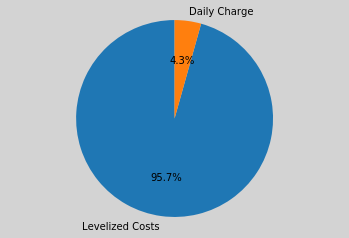

ERROR:ga_logger:panel values: (159.48445109016222, 186.765086133731, 173.7901089493817, 26.91313638615194, 31.53937531300682, 20.231138677673165, 0.6718192712921558, 0.5161738472813525, 0.5459570784294522)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 159
                                           a tilt of 26.9
                                           and a gcr of 0.672


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7328603267669678 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 31.5
                                           and a gcr of 0.516


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4214930534362793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 20.2
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.43387508392334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 295.805276617293, 0.0]


ERROR:ga_logger:Cost: 3071.053614750582


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


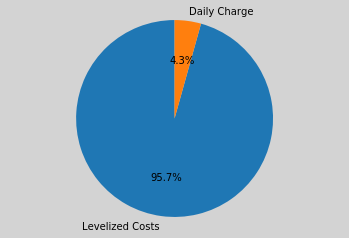

ERROR:ga_logger:panel values: (157.57187630325757, 182.75636484854118, 168.15226413504053, 25.41835133546656, 29.381245734691685, 21.002872129538304, 0.6669683258483057, 0.5128457005383633, 0.5577561885005191)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 25.4
                                           and a gcr of 0.667


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6509268283843994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 29.4
                                           and a gcr of 0.513


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3813560009002686 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 21.0
                                           and a gcr of 0.558


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4351134300231934 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 294.91249069731356, 0.0]


ERROR:ga_logger:Cost: 3062.1862849172912


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


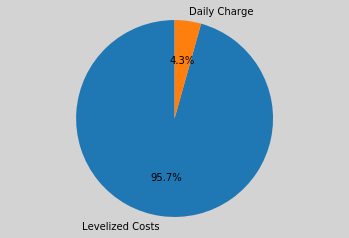

ERROR:ga_logger:panel values: (157.35971901369408, 181.01578726979827, 169.29590012996036, 25.632542510129724, 30.616494309230454, 20.964589045188916, 0.6642095539560386, 0.5041047231385523, 0.5492840919590536)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.6
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.717245101928711 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 30.6
                                           and a gcr of 0.504


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.440307378768921 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.0
                                           and a gcr of 0.549


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6646697521209717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 159 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 294.32922606868203, 0.0]


ERROR:ga_logger:Cost: 3056.393184977176


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


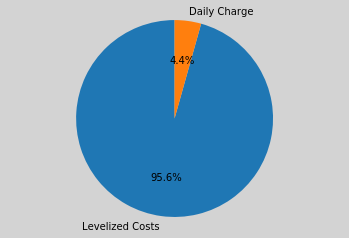

ERROR:ga_logger:panel values: (157.37364987952046, 182.72143818519854, 169.4607539503682, 25.91753478163283, 30.240172496079854, 21.07043824323241, 0.665511107231624, 0.49957832113488443, 0.551852722634798)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.9
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.907580614089966 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 30.2
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3782436847686768 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.552


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.400449275970459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 294.49919893295305, 0.0]


ERROR:ga_logger:Cost: 3058.0813890052177


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (157.55491223324222, 182.46525004355965, 169.02730244499506, 25.872290904550415, 30.24321554234119, 20.705883050164413, 0.6663779149312292, 0.5005696752089137, 0.5508879262574848)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 25.9
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.68253231048584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 30.2
                                           and a gcr of 0.501


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3697261810302734 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 20.7
                                           and a gcr of 0.551


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5263402462005615 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 294.48120142557417, 0.0]


ERROR:ga_logger:Cost: 3057.9026341917674


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (90.2819260304211, 99.12165716205553, 262.21675392952847, 1.2056138412810948, 55.04119584517126, 55.284658615831695, 0.8777461851022652, 0.2340077445118407, 0.4127956734089119)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.2
                                           and a gcr of 0.878


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.533273458480835 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 99
                                           a tilt of 55.0
                                           and a gcr of 0.234


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3735475540161133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 262
                                           a tilt of 55.3
                                           and a gcr of 0.413


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.745011806488037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 157 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [335.9097496109604, 0.0, 0.0]


ERROR:ga_logger:Cost: 3469.379230272226


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


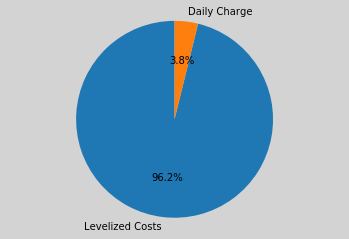

ERROR:ga_logger:panel values: (91.48120462738362, 180.63186489969723, 175.38803972244762, 2.201753336253712, 54.219947316808806, 36.08814793912363, 0.8871039957458347, 0.344292729311938, 0.7652040151135984)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 2.2
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5833852291107178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 54.2
                                           and a gcr of 0.344


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4177746772766113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 36.1
                                           and a gcr of 0.765


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4980196952819824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 120.82568180103789, 189.63505365277996]


ERROR:ga_logger:Cost: 3216.6145715184966


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


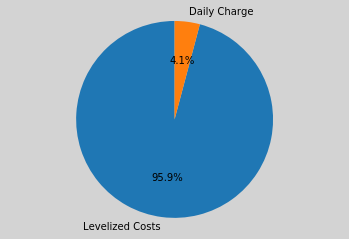

ERROR:ga_logger:panel values: (99.40242288556117, 171.28889812380038, 235.02670331395035, 1.987090345022728, 43.014861767177685, 6.53484431115707, 0.8718107066523675, 0.7032760974096213, 0.8725246875123016)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 99
                                           a tilt of 2.0
                                           and a gcr of 0.872


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8778181076049805 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 43.0
                                           and a gcr of 0.703


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.474821090698242 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 6.5
                                           and a gcr of 0.873


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.473405361175537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 315.41760073006054, 0.0]


ERROR:ga_logger:Cost: 3265.847150738206


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


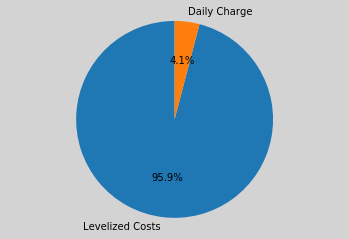

ERROR:ga_logger:panel values: (128.50958838829422, 178.25112737205038, 181.58761203940884, 22.612494753048985, 29.201375048222584, 29.914438742659996, 0.5851783685988068, 0.4076244910093786, 0.605999003543255)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 129
                                           a tilt of 22.6
                                           and a gcr of 0.585


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.240247964859009 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 29.2
                                           and a gcr of 0.408


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3534374237060547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 29.9
                                           and a gcr of 0.606


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3949711322784424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile

ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 138.0228692888378, 157.65591083573338]


ERROR:ga_logger:Cost: 3069.797224894829


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (146.18753350996695, 180.12065460918896, 168.14016142427062, 23.69731751534842, 33.03913923882146, 23.96199197531646, 0.6362269746162434, 0.4623122964635532, 0.5569113163291963)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 146
                                           a tilt of 23.7
                                           and a gcr of 0.636


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.197782039642334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 33.0
                                           and a gcr of 0.462


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4025967121124268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 24.0
                                           and a gcr of 0.557


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3932371139526367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s

ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 185.57191854835048, 109.91323945773927]


ERROR:ga_logger:Cost: 3067.8741308312397


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (156.60234439957222, 180.0349259459473, 168.62870800516237, 25.370038473918903, 31.083170188719354, 20.984561058226667, 0.6617695394897686, 0.49581276435937366, 0.5461412930380605)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.4
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8675172328948975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.1
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4611494541168213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.0
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4288642406463623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 293.9692744065799, 0.0]


ERROR:ga_logger:Cost: 3052.818073397841


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (90.98538487158184, 91.27587598685233, 184.78355028147718, 54.81046788483322, 26.16707780348195, 53.10568384525473, 0.8970014376159678, 0.8826487775025131, 0.8958387690801326)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 54.8
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.093866586685181 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 91
                                           a tilt of 26.2
                                           and a gcr of 0.883


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3626744747161865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 53.1
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9347434043884277 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 341.5899583018836]


ERROR:ga_logger:Cost: 3525.7962521039285


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


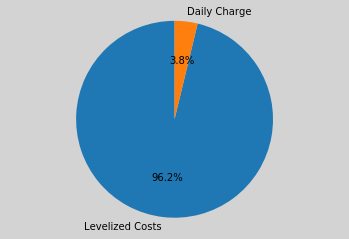

ERROR:ga_logger:panel values: (97.9937370871646, 126.04685045860711, 195.7685592399666, 15.002768802587692, 37.9438267713439, 48.86835560011199, 0.8997189066947953, 0.829700863188201, 0.5936535398201499)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 98
                                           a tilt of 15.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.597815036773682 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 126
                                           a tilt of 37.9
                                           and a gcr of 0.830


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4003701210021973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 196
                                           a tilt of 48.9
                                           and a gcr of 0.594


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.508213758468628 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 317.41534111397243]


ERROR:ga_logger:Cost: 3285.6891351457252


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


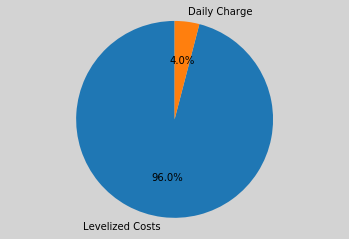

ERROR:ga_logger:panel values: (103.77739660411285, 123.79624841480575, 238.86639373642282, 3.641946432052506, 22.551543023858763, 32.06891229256119, 0.8943402291306883, 0.42395882262415663, 0.42949434312003365)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 104
                                           a tilt of 3.6
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.277364253997803 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 124
                                           a tilt of 22.6
                                           and a gcr of 0.424


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3538906574249268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 239
                                           a tilt of 32.1
                                           and a gcr of 0.429

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4039254188537598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [132.86351809459495, 190.8668165284255, 0.0]


ERROR:ga_logger:Cost: 3348.4108539201825


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (139.0544085310403, 180.42643654074448, 168.06249121184106, 28.441220605013132, 27.20364133940706, 26.12138037290822, 0.5904046078362237, 0.4837155114141566, 0.6295243406727762)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 28.4
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8486826419830322 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 27.2
                                           and a gcr of 0.484


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.419168710708618 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 26.1
                                           and a gcr of 0.630


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5677976608276367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 272.2736283068561, 22.58859830065331]


ERROR:ga_logger:Cost: 3061.6870498577555


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


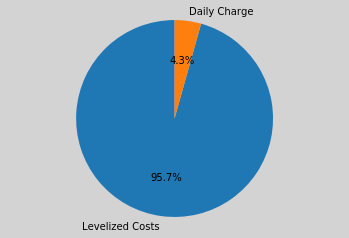

ERROR:ga_logger:panel values: (128.15227933874758, 174.59905160144996, 175.6491429594092, 27.699398478018434, 25.31331593505558, 24.849101984530638, 0.5548006857822994, 0.4331219031642086, 0.6478258240814652)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 128
                                           a tilt of 27.7
                                           and a gcr of 0.555


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.765748500823975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 25.3
                                           and a gcr of 0.433


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.450330972671509 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 24.8
                                           and a gcr of 0.648


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.356083869934082 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 182.3819598167323, 115.10231110110256]


ERROR:ga_logger:Cost: 3087.7297164814318


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (155.99358073304364, 178.8995949079852, 167.68879835028332, 25.202398168153614, 31.406789281123505, 20.87031418299185, 0.6591191355296279, 0.4867650832868855, 0.5415331327793886)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.2
                                           and a gcr of 0.659


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.784688472747803 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 31.4
                                           and a gcr of 0.487


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5371458530426025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 20.9
                                           and a gcr of 0.542


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5263705253601074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [16.036200517415864, 279.6134092379471, 0.0]


ERROR:ga_logger:Cost: 3069.5074995219884


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


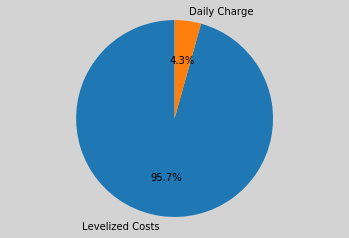

ERROR:ga_logger:panel values: (238.65794314961414, 97.60940001586481, 203.2282645192802, 41.99253681067348, 55.61713928653302, 33.99201096057187, 0.8984066815788005, 0.8231059815514248, 0.8214619548439603)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 239
                                           a tilt of 42.0
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.333164930343628 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 98
                                           a tilt of 55.6
                                           and a gcr of 0.823


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.529512643814087 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 203
                                           a tilt of 34.0
                                           and a gcr of 0.821


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4219796657562256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 325.3321620628213]


ERROR:ga_logger:Cost: 3364.3205489357124


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


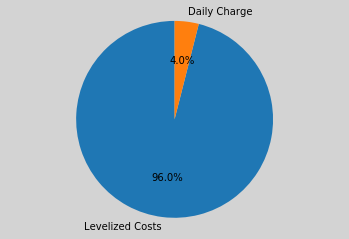

ERROR:ga_logger:panel values: (198.11283560689452, 102.58487525843591, 222.13600438272314, 30.423492572774464, 44.71682636474044, 1.5071942430256242, 0.8999157735937193, 0.5132730106440241, 0.8804134848897285)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 198
                                           a tilt of 30.4
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.266486644744873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 103
                                           a tilt of 44.7
                                           and a gcr of 0.513


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.83696436882019 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 222
                                           a tilt of 1.5
                                           and a gcr of 0.880


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2038512229919434 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [327.2492433903175, 0.0, 0.0]


ERROR:ga_logger:Cost: 3383.3613830267195


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


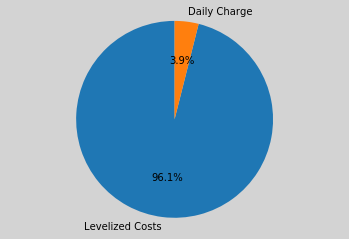

ERROR:ga_logger:panel values: (195.062055215591, 196.95706916190125, 188.94349546780427, 1.0499303023679287, 16.426036697834242, 39.1589915593412, 0.8957414034750038, 0.8655743961265374, 0.5621533176936697)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 1.0
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1380817890167236 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 197
                                           a tilt of 16.4
                                           and a gcr of 0.866


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4129433631896973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 189
                                           a tilt of 39.2
                                           and a gcr of 0.562


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4415812492370605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 301.25978836164495]


ERROR:ga_logger:Cost: 3125.228922475344


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


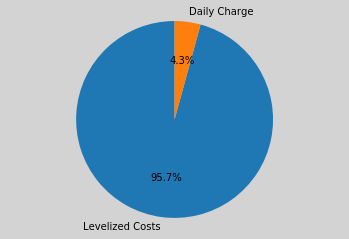

ERROR:ga_logger:panel values: (159.78908873164644, 189.39236944700122, 162.3982445026461, 17.32097985606131, 35.21505063331094, 29.522684752154053, 0.7631165969237248, 0.5220682961254782, 0.6063320774048397)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 17.3
                                           and a gcr of 0.763


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.900570869445801 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 35.2
                                           and a gcr of 0.522


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3944010734558105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 29.5
                                           and a gcr of 0.606


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3949649333953857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 297.43733763730256, 0.0]


ERROR:ga_logger:Cost: 3087.2635739351304


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (141.92429456345883, 183.86994977595032, 167.60382058959652, 24.422530445770686, 30.137420501761454, 26.72315938087677, 0.6106709048406405, 0.47110086398352113, 0.6014264200624297)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 142
                                           a tilt of 24.4
                                           and a gcr of 0.611


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.18240213394165 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 30.1
                                           and a gcr of 0.471


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.538022756576538 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 26.7
                                           and a gcr of 0.601


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5469810962677 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 234.05179023225784, 61.31111104485287]


ERROR:ga_logger:Cost: 3066.659852447989


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (156.63634408555018, 180.41776853569667, 168.85672948712846, 25.36363226778857, 31.05328175849309, 21.05552767483002, 0.6619274645255011, 0.49750412104725666, 0.5479185659448031)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.4
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9474921226501465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.1
                                           and a gcr of 0.498


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3837220668792725 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.548


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.368126392364502 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 294.065539247105, 0.0]


ERROR:ga_logger:Cost: 3053.77419502676


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


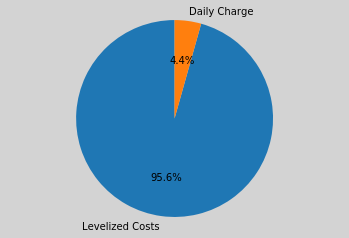

ERROR:ga_logger:panel values: (157.26159257270533, 181.57942287182635, 170.69108480204255, 25.942552676920272, 32.00155301491881, 20.734129150938486, 0.6635957178699572, 0.4961543240173239, 0.5400842744660882)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.9
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.237559795379639 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 32.0
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4652116298675537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 171
                                           a tilt of 20.7
                                           and a gcr of 0.540


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.523292064666748 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 294.2406525779584, 0.0]


ERROR:ga_logger:Cost: 3055.513456329134


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


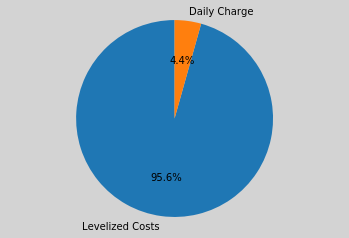

ERROR:ga_logger:panel values: (157.04033795798307, 178.88426562621007, 169.7203869145821, 25.395356306659167, 31.09806346194649, 20.889975830483927, 0.6656530855849399, 0.4929786124000652, 0.5506437327286309)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.4
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.631806135177612 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 31.1
                                           and a gcr of 0.493


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5275204181671143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 20.9
                                           and a gcr of 0.551


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.356034994125366 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.007260633358020948, 295.1713255658284, 0.0]


ERROR:ga_logger:Cost: 3064.8291994828073


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (156.7528924884453, 180.28763043508758, 168.86409715919694, 25.13444569960469, 31.025353447887237, 21.039479373833764, 0.6640849739664811, 0.4955817490929318, 0.5440513111519529)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.1
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.817402124404907 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.517284631729126 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.0
                                           and a gcr of 0.544


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.397873878479004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 293.9976999065382, 0.0]


ERROR:ga_logger:Cost: 3053.100401087864


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (156.17157151507985, 180.00529559523324, 168.51864564910383, 25.41261582634583, 31.099441792293945, 21.0004059453402, 0.663118123501796, 0.49618698720566123, 0.5460655585010303)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.4
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9097092151641846 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.1
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.368709087371826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.0
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5226686000823975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 293.9749820375408, 0.0]


ERROR:ga_logger:Cost: 3052.8747627491607


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (156.67847785466824, 180.02207236047732, 168.60873219617386, 25.40847573453304, 31.07349098376925, 21.05913914700989, 0.6618802697253894, 0.49552124237417633, 0.5459825487723822)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.4
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.189887046813965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.1
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3684744834899902 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.416191816329956 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 293.9600619102434, 0.0]


ERROR:ga_logger:Cost: 3052.7265730308773


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


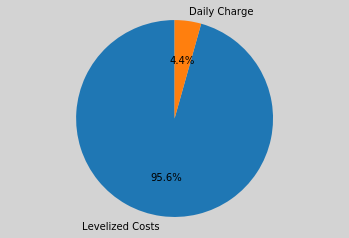

ERROR:ga_logger:panel values: (205.17157650340738, 112.9571356061009, 94.30914995654376, 48.01973919166717, 1.1601237166456677, 48.028329572867676, 0.8986835886925142, 0.8953962327167091, 0.3646500815657921)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 48.0
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.6947340965271 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 113
                                           a tilt of 1.2
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0434396266937256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 94
                                           a tilt of 48.0
                                           and a gcr of 0.365


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.137901306152344 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 334.6851265839502, 0.0]


ERROR:ga_logger:Cost: 3457.216029814364


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


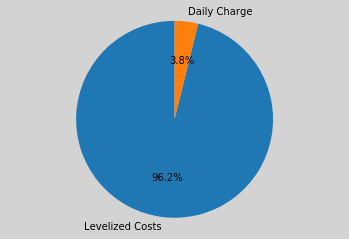

ERROR:ga_logger:panel values: (190.8710580810298, 91.56296718734332, 233.22489503521962, 35.12818480590185, 2.548355882507402, 34.29415640290087, 0.8985906315898116, 0.8676509454404047, 0.6342763113951437)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 191
                                           a tilt of 35.1
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.053927898406982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 92
                                           a tilt of 2.5
                                           and a gcr of 0.868


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.211730480194092 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 233
                                           a tilt of 34.3
                                           and a gcr of 0.634


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.337451934814453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [325.32298763412444, 0.0, 0.0]


ERROR:ga_logger:Cost: 3364.2294313383977


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


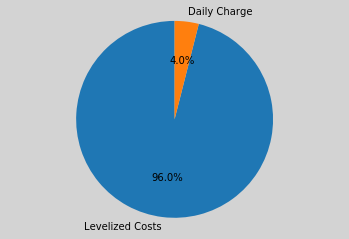

ERROR:ga_logger:panel values: (233.46158911013666, 147.89037789995842, 160.7943354775869, 27.15796075719433, 25.560285110186644, 18.634204052151137, 0.8946899862157205, 0.8602367642417261, 0.5338947190407423)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 233
                                           a tilt of 27.2
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.996828317642212 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 148
                                           a tilt of 25.6
                                           and a gcr of 0.860


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3234176635742188 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 161
                                           a tilt of 18.6
                                           and a gcr of 0.534


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3353331089019775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s

ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 303.000456518067]


ERROR:ga_logger:Cost: 3142.517568483666


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (182.90037833894047, 174.11007874646515, 161.33527619359398, 24.065393539667678, 29.363134658650946, 29.327592524378918, 0.7753885595058456, 0.6078737025333052, 0.48848447666568245)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 24.1
                                           and a gcr of 0.775


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.015056848526001 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 29.4
                                           and a gcr of 0.608


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.282252311706543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 161
                                           a tilt of 29.3
                                           and a gcr of 0.488


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2767069339752197 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 28.920170757288034, 269.24567193085625]


ERROR:ga_logger:Cost: 3094.4992259794426


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (128.68315126915476, 191.5476833303094, 173.54064044826185, 20.406261995856685, 36.22587925751039, 29.92576825222736, 0.628117571843354, 0.510933303833776, 0.5102737448986951)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 129
                                           a tilt of 20.4
                                           and a gcr of 0.628


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.972127914428711 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 36.2
                                           and a gcr of 0.511

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3832998275756836 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 29.9
                                           and a gcr of 0.510


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.329603910446167 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.0538740151381]


ERROR:ga_logger:Cost: 3073.5227322209985


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


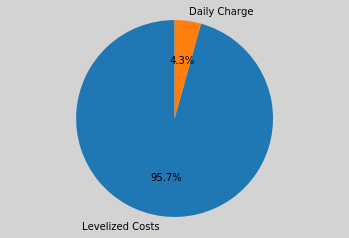

ERROR:ga_logger:panel values: (190.41983934173754, 183.34251368374805, 145.69930488668973, 12.747283183232183, 33.627154564698046, 8.769431257408296, 0.8999999999992057, 0.607623215103236, 0.5020624168261663)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 12.7
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.773954153060913 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 33.6
                                           and a gcr of 0.608


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.300687789916992 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 146
                                           a tilt of 8.8
                                           and a gcr of 0.502


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3439643383026123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 159 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 299.1656055754435, 0.0]


ERROR:ga_logger:Cost: 3104.4290770913112


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


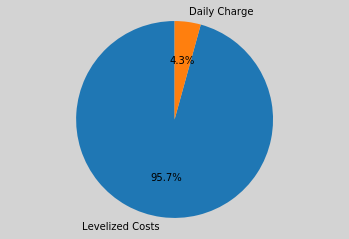

ERROR:ga_logger:panel values: (90.08082175753106, 264.1353958695918, 123.76866550750199, 20.85928749951925, 5.0309744129043725, 54.071889292708256, 0.8891316385398749, 0.893964163584192, 0.8790418012219339)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 20.9
                                           and a gcr of 0.889


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.108166694641113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 5.0
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8752410411834717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 124
                                           a tilt of 54.1
                                           and a gcr of 0.879


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3597822189331055 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 166 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 339.7092461918987, 0.0]


ERROR:ga_logger:Cost: 3507.1165905790185


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


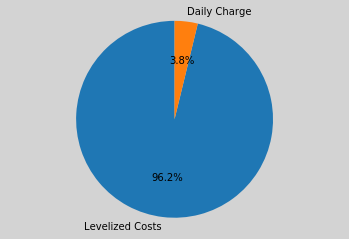

ERROR:ga_logger:panel values: (102.01104221967907, 145.14495219855755, 210.0804215625696, 53.24156573934464, 8.384904024251444, 3.129266142913871, 0.5280651549694184, 0.892155949454116, 0.8989859267744231)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 102
                                           a tilt of 53.2
                                           and a gcr of 0.528


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.980083703994751 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 8.4
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.4755613803863525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 3.1
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2296292781829834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 168 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 326.6889051443221, 0.0]


ERROR:ga_logger:Cost: 3377.79596688922


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


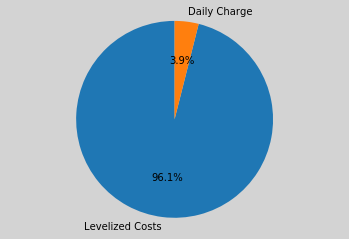

ERROR:ga_logger:panel values: (152.04025086619998, 148.9690429724957, 213.64223646926007, 19.569626504914485, 19.791677559994472, 22.421707872047428, 0.8971071501893737, 0.8329127085558286, 0.6062246165241838)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 19.6
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.11048150062561 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 149
                                           a tilt of 19.8
                                           and a gcr of 0.833


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3579604625701904 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 214
                                           a tilt of 22.4
                                           and a gcr of 0.606


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.373788833618164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 170 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 310.3043598049604]


ERROR:ga_logger:Cost: 3215.0613979270743


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


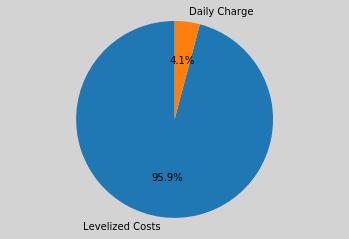

ERROR:ga_logger:panel values: (145.86491478693586, 184.50235456491353, 172.84804439601345, 23.07837815064638, 28.89073535056763, 29.7298689397743, 0.643618278502388, 0.5182499779111855, 0.5086935077164649)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 146
                                           a tilt of 23.1
                                           and a gcr of 0.644


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.120178461074829 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 28.9
                                           and a gcr of 0.518


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4162051677703857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 29.7
                                           and a gcr of 0.509


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.403074026107788 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 167 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 295.4257188235279, 0.0]


ERROR:ga_logger:Cost: 3067.2837688552913


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


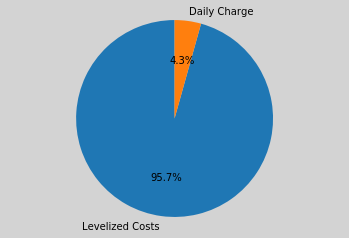

ERROR:ga_logger:panel values: (128.87028741783578, 181.53183309303466, 169.4055185711486, 30.881864630308762, 34.595888248528844, 30.016893415153547, 0.6109697282376276, 0.4529596356567873, 0.5968600491556388)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 129
                                           a tilt of 30.9
                                           and a gcr of 0.611


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.344398021697998 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 34.6
                                           and a gcr of 0.453


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3941171169281006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 30.0
                                           and a gcr of 0.597


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3943393230438232 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 169 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 193.84330001839072, 101.95169103269416]


ERROR:ga_logger:Cost: 3070.951457344867


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


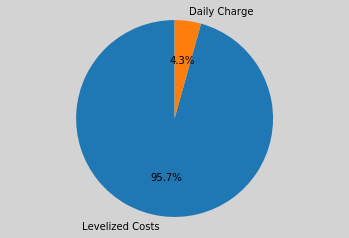

ERROR:ga_logger:panel values: (155.17416679221665, 184.12323466574793, 167.38711753606975, 24.90044287425319, 31.199121963792464, 21.539334947797343, 0.662920255630734, 0.5115381229476272, 0.5239584617307202)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 24.9
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.115937948226929 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 31.2
                                           and a gcr of 0.512


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4327614307403564 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 21.5
                                           and a gcr of 0.524


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3636016845703125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 166 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 295.0830156415532, 0.0]


ERROR:ga_logger:Cost: 3063.879974150632


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


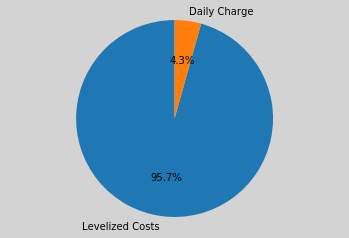

ERROR:ga_logger:panel values: (242.1067785644975, 96.01083360079129, 92.54088215757348, 54.98264942315238, 54.985143462897504, 1.8976001187256666, 0.8973228398770818, 0.48323094446576603, 0.48852246202148036)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 242
                                           a tilt of 55.0
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.179478168487549 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 55.0
                                           and a gcr of 0.483


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4048140048980713 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 1.9
                                           and a gcr of 0.489


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.37996244430542 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 164 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [204.89750636704477, 0.0, 180.95778233427274]


ERROR:ga_logger:Cost: 3965.4483269752013


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


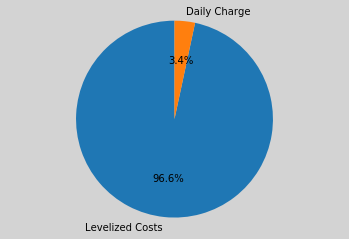

ERROR:ga_logger:panel values: (206.1300309025341, 259.4595533539806, 105.25004368726057, 18.211217260964553, 1.5503037337139367, 11.84606234222337, 0.7026128208617601, 0.8847110617902008, 0.5752324869431316)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 206
                                           a tilt of 18.2
                                           and a gcr of 0.703


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.2461323738098145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 259
                                           a tilt of 1.6
                                           and a gcr of 0.885


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.887483596801758 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 11.8
                                           and a gcr of 0.575


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4074957370758057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 161 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [311.5831042180622, 0.0, 0.0]


ERROR:ga_logger:Cost: 3227.762141207822


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


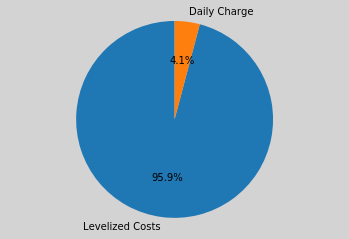

ERROR:ga_logger:panel values: (182.79158621530647, 174.8397617935414, 146.98271804390365, 1.2770592870137207, 42.53478492741605, 30.403775099030334, 0.8974172248041858, 0.830050088171016, 0.895217591500969)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 1.3
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.045020341873169 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 42.5
                                           and a gcr of 0.830


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3818507194519043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 147
                                           a tilt of 30.4
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.389465570449829 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 154 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 324.2582556364231, 0.0]


ERROR:ga_logger:Cost: 3353.6543054835925


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


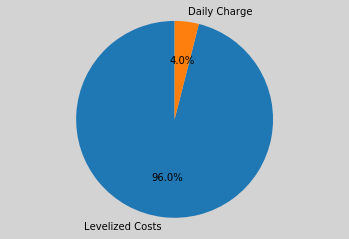

ERROR:ga_logger:panel values: (128.93416912932645, 180.39948337907717, 172.11226127309004, 21.2138296715306, 33.99447556374194, 30.087848280486856, 0.6666260186002537, 0.4354915774655782, 0.5703335452961127)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 129
                                           a tilt of 21.2
                                           and a gcr of 0.667


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5587048530578613 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 34.0
                                           and a gcr of 0.435


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3304083347320557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 30.1
                                           and a gcr of 0.570


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3384032249450684 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  17 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 155 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 148.10759808993126, 147.52747702454963]


ERROR:ga_logger:Cost: 3069.363139531543


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


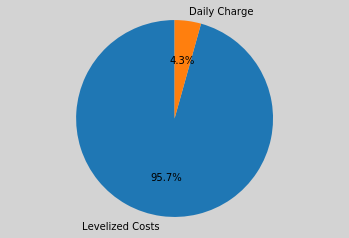

ERROR:ga_logger:panel values: (140.16977840812058, 180.66521868827394, 183.87238841766487, 23.709748264741954, 30.594489053577867, 29.69016405158919, 0.5907848888961759, 0.47324392401011367, 0.5424607391681417)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 23.7
                                           and a gcr of 0.591


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.201381683349609 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 30.6
                                           and a gcr of 0.473


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4381086826324463 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 29.7
                                           and a gcr of 0.542


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3760716915130615 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile

ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 209.1935997536639, 85.01437829403118]


ERROR:ga_logger:Cost: 3055.18892498092


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


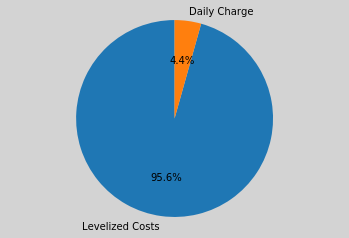

ERROR:ga_logger:panel values: (147.2090711862635, 178.9438547096425, 182.01003765477907, 22.49659104077662, 28.15247791949204, 37.562052494897216, 0.5972662864954934, 0.48052133563563765, 0.5522551543869816)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 147
                                           a tilt of 22.5
                                           and a gcr of 0.597


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.014343976974487 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 28.2
                                           and a gcr of 0.481


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4266107082366943 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 37.6
                                           and a gcr of 0.552


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4114420413970947 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  19 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 234.8562892910815, 60.75280956617917]


ERROR:ga_logger:Cost: 3069.1051365919348


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


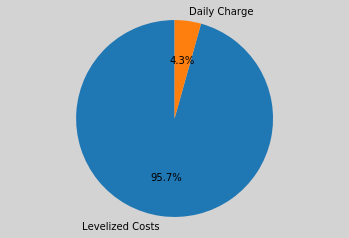

ERROR:ga_logger:panel values: (157.001086998059, 180.83527676622327, 169.60793877838637, 25.69660745065629, 31.53686975825484, 20.937164767750662, 0.6627114027389086, 0.49578089896338795, 0.5427966092772145)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.7
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.210748672485352 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 31.5
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3863742351531982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 20.9
                                           and a gcr of 0.543


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3816187381744385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 294.0909110098339, 0.0]


ERROR:ga_logger:Cost: 3054.0261927921038


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


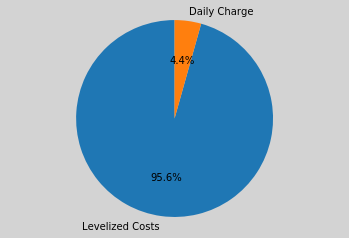

ERROR:ga_logger:panel values: (157.24169663609894, 180.06851113365565, 167.84610019835668, 25.377027086994794, 31.220698847017015, 21.032278988053164, 0.6635671077004679, 0.49620036255281935, 0.5469481639449136)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.4
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.218530178070068 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.2
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.476447582244873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 21.0
                                           and a gcr of 0.547


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4121787548065186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 293.9847000739302, 0.0]


ERROR:ga_logger:Cost: 3052.971284324542


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


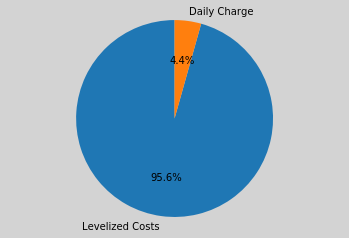

ERROR:ga_logger:panel values: (156.6974057702436, 179.6749685894822, 168.67709863996095, 25.377066761902576, 31.12360486706814, 21.108342391582166, 0.6614696332547256, 0.49698759927745395, 0.5454127253721388)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.4
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.696918725967407 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.1
                                           and a gcr of 0.497


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.385232448577881 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3799352645874023 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 149 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 295.3067763654853, 0.0]


ERROR:ga_logger:Cost: 3066.1024099187493


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


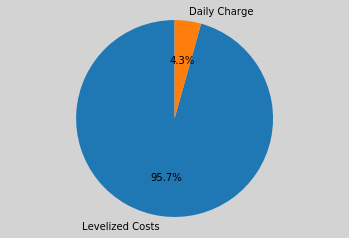

ERROR:ga_logger:panel values: (156.6507577699167, 180.21731374880744, 168.52848637546907, 25.42260063749709, 31.04744451591932, 21.03880087154167, 0.661904744069746, 0.4948451496010089, 0.5460849102052211)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.4
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.615280866622925 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.495


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.755186080932617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.0
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.395965814590454 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 293.96913620150605, 0.0]


ERROR:ga_logger:Cost: 3052.8167006683566


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


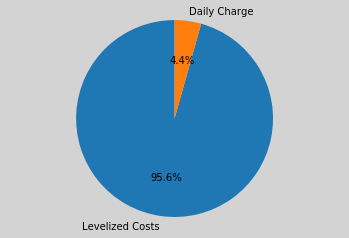

ERROR:ga_logger:panel values: (237.78513604229826, 251.82432724835226, 198.03468425574005, 51.59455726392169, 3.498021982975156, 47.82402908205171, 0.7574911711190655, 0.8692359092230595, 0.6956851460514287)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 238
                                           a tilt of 51.6
                                           and a gcr of 0.757


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.160924196243286 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 252
                                           a tilt of 3.5
                                           and a gcr of 0.869


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.282838582992554 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 47.8
                                           and a gcr of 0.696


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3855605125427246 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 325.5621792095578]


ERROR:ga_logger:Cost: 3366.6051610202107


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


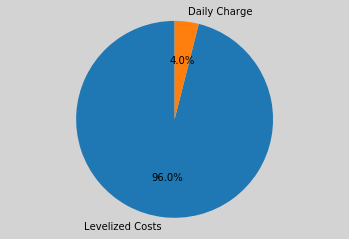

ERROR:ga_logger:panel values: (126.02953970383774, 260.1137661851326, 150.3187661935978, 31.377715673019775, 1.7825658676330876, 51.976563731886344, 0.7887742826046371, 0.8589848511323566, 0.22883705439238436)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 31.4
                                           and a gcr of 0.789


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.724407911300659 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 1.8
                                           and a gcr of 0.859


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.684123516082764 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 52.0
                                           and a gcr of 0.229


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.385422468185425 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 262.9197873422102, 66.97595981482593]


ERROR:ga_logger:Cost: 3409.6469625727914


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


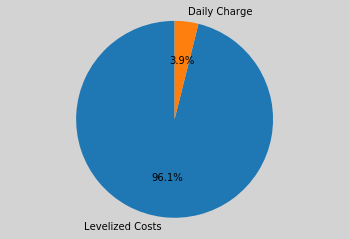

ERROR:ga_logger:panel values: (198.5995776764874, 198.97203728059188, 141.72652755366113, 31.58648217538306, 5.687497909315251, 40.40530071083726, 0.8269370973441217, 0.8861017964822284, 0.48280589336732455)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 199
                                           a tilt of 31.6
                                           and a gcr of 0.827


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.346139669418335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 199
                                           a tilt of 5.7
                                           and a gcr of 0.886


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.423689842224121 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 142
                                           a tilt of 40.4
                                           and a gcr of 0.483


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5009748935699463 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [64.5107695432071, 0.0, 251.42115942561045]


ERROR:ga_logger:Cost: 3270.9555516041396


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


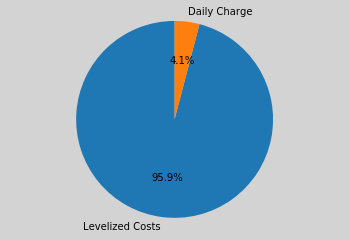

ERROR:ga_logger:panel values: (182.1330813250437, 190.0859951668876, 163.58082156875923, 16.955534986850616, 33.69201206903405, 19.447575894541522, 0.7691198811094215, 0.5422142336033622, 0.5023126194175789)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 182
                                           a tilt of 17.0
                                           and a gcr of 0.769


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.314508438110352 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 33.7
                                           and a gcr of 0.542


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.349126100540161 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 164
                                           a tilt of 19.4
                                           and a gcr of 0.502


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.344972610473633 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 297.96554292616634, 0.0]


ERROR:ga_logger:Cost: 3092.5098135168287


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


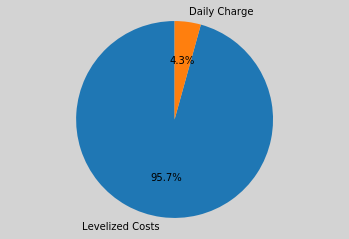

ERROR:ga_logger:panel values: (136.10620876520477, 179.5061156770238, 180.60694134142778, 24.510139726173286, 28.870472400171998, 29.79063914726113, 0.6637474148372178, 0.5079143934495005, 0.5899722002965376)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 24.5
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.309020042419434 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 28.9
                                           and a gcr of 0.508


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.375288486480713 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 29.8
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.739495038986206 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 295.6822805990282, 0.0]


ERROR:ga_logger:Cost: 3069.831991371479


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


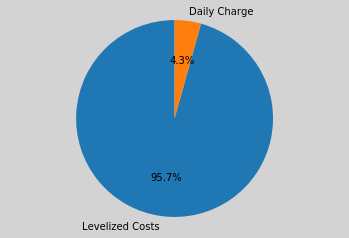

ERROR:ga_logger:panel values: (156.6523419248664, 181.06711012771368, 168.3919030974568, 25.386981949105365, 31.099916192191337, 20.948213442124946, 0.6643504265833937, 0.4956423879153983, 0.5463994230769793)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.4
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.848598957061768 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 31.1
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.436922788619995 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 20.9
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3742058277130127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 294.11248996307836, 0.0]


ERROR:ga_logger:Cost: 3054.2405189099068


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


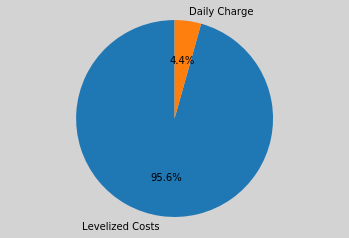

ERROR:ga_logger:panel values: (166.40670148379075, 224.34791744626318, 97.99403978904454, 52.69364984224969, 54.06487246164265, 55.853399929709866, 0.7174962770879496, 0.899553964993089, 0.8773449981098749)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 52.7
                                           and a gcr of 0.717


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.3580162525177 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 224
                                           a tilt of 54.1
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.822114706039429 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 98
                                           a tilt of 55.9
                                           and a gcr of 0.877


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.612049102783203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  17 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [333.12739547154337, 0.0, 0.0]


ERROR:ga_logger:Cost: 3441.744379749297


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


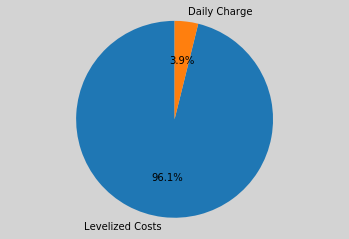

ERROR:ga_logger:panel values: (101.3583019699328, 254.4097727843085, 91.01445419145075, 50.20971870424743, 50.65536629332944, 10.742071199884734, 0.5533120027563445, 0.7815667413089946, 0.8615664865857235)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 101
                                           a tilt of 50.2
                                           and a gcr of 0.553


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.382191181182861 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 254
                                           a tilt of 50.7
                                           and a gcr of 0.782


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5548460483551025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 10.7
                                           and a gcr of 0.862


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.424516201019287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 349.42903070763174]


ERROR:ga_logger:Cost: 3603.6554347960673


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


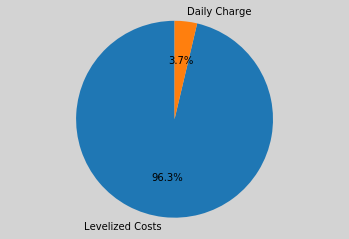

ERROR:ga_logger:panel values: (205.78441798123953, 193.90263350388773, 178.60601795547296, 38.37037241579285, 2.452520526526811, 10.868124664439195, 0.6584719936523404, 0.7937021417217276, 0.6498280980623912)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 206
                                           a tilt of 38.4
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.386115789413452 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 194
                                           a tilt of 2.5
                                           and a gcr of 0.794


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.200270891189575 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 10.9
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.381936550140381 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.9628498309988]


ERROR:ga_logger:Cost: 3231.533844446457


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


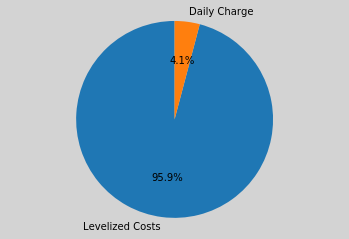

ERROR:ga_logger:panel values: (151.82407932892545, 184.2717718573764, 175.71872672961072, 30.068730223227384, 27.239956036140715, 29.58739484635433, 0.6256740900396485, 0.4629886145123244, 0.5496399492020136)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 30.1
                                           and a gcr of 0.626


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.885841608047485 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 27.2
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.476151704788208 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 29.6
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4909284114837646 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  17 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 179.49713000072788, 116.01215306767077]


ERROR:ga_logger:Cost: 3068.113744694428


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


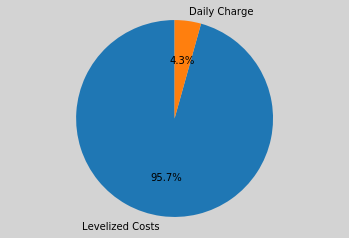

ERROR:ga_logger:panel values: (139.15665754253897, 182.41611756034905, 174.63791843711755, 26.945671231262928, 30.77296923960371, 29.981797787539573, 0.6290074791782634, 0.47867849846032623, 0.5842591647899729)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 26.9
                                           and a gcr of 0.629


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.814815998077393 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 30.8
                                           and a gcr of 0.479


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.368004560470581 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 30.0
                                           and a gcr of 0.584


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3917858600616455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 250.30405843293428, 44.31913340639466]


ERROR:ga_logger:Cost: 3059.3129115462007


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


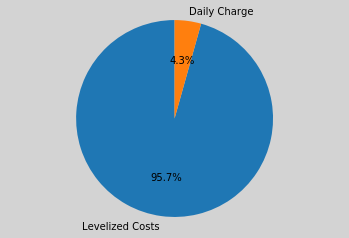

ERROR:ga_logger:panel values: (156.5426236157625, 180.31407853310995, 168.55033099338453, 25.38856327170739, 31.068314347195738, 20.984358839962432, 0.6627475964375005, 0.49553400618205, 0.5464107699825185)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.4
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.38782000541687 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.1
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.388568878173828 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.0
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4088687896728516 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 294.00008981887817, 0.0]


ERROR:ga_logger:Cost: 3053.1241382077897


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


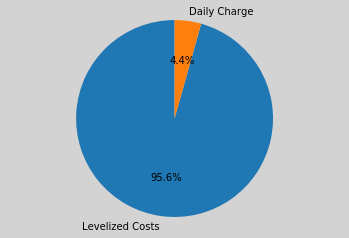

ERROR:ga_logger:panel values: (190.8607924948738, 215.0415528692216, 257.9600172651493, 30.15790206419637, 36.69036389061158, 54.33397292409267, 0.8896250862447712, 0.8724031919910409, 0.8814437197970202)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 191
                                           a tilt of 30.2
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.762972116470337 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 36.7
                                           and a gcr of 0.872


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3821864128112793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 258
                                           a tilt of 54.3
                                           and a gcr of 0.881


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3831138610839844 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 149 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [321.6555361978143, 0.0, 0.0]


ERROR:ga_logger:Cost: 3327.803565467264


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


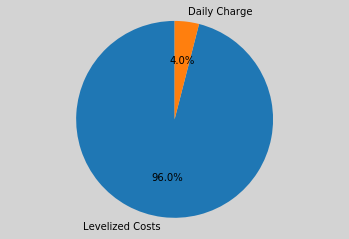

ERROR:ga_logger:panel values: (157.78670581409386, 256.0612313732002, 96.31271061694862, 10.746339674367617, 48.15088901222175, 55.52719807040658, 0.8942896841805685, 0.8567742937738987, 0.39841104928031046)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 10.7
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.438822031021118 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 256
                                           a tilt of 48.2
                                           and a gcr of 0.857


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3944761753082275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 96
                                           a tilt of 55.5
                                           and a gcr of 0.398


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3972320556640625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [323.72738961197336, 0.0, 0.0]


ERROR:ga_logger:Cost: 3348.3816059625906


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


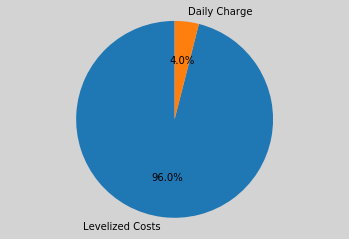

ERROR:ga_logger:panel values: (236.16080478771494, 211.42811087585358, 160.5270750537033, 25.84251055402967, 37.211259259909745, 45.43634163451026, 0.887541737489695, 0.837397806098436, 0.7084883444636438)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 236
                                           a tilt of 25.8
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.702730894088745 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 211
                                           a tilt of 37.2
                                           and a gcr of 0.837


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.385547399520874 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 161
                                           a tilt of 45.4
                                           and a gcr of 0.708


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.373617649078369 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 164 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 324.53004013410794]


ERROR:ga_logger:Cost: 3356.3537213329596


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


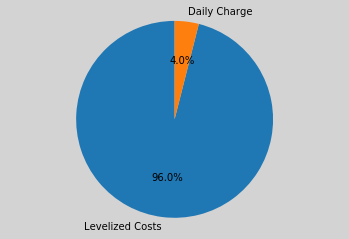

ERROR:ga_logger:panel values: (147.33573257164295, 191.71394297734696, 166.51378333704096, 22.109178161937027, 34.77359169735256, 29.695102324287223, 0.6643976000478912, 0.4640451410346282, 0.5212797337723282)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 147
                                           a tilt of 22.1
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.445898056030273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 34.8
                                           and a gcr of 0.464


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.40659499168396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 29.7
                                           and a gcr of 0.521


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4691851139068604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 171 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 122.14521590892556, 174.91191637363423]


ERROR:ga_logger:Cost: 3083.4872948609786


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


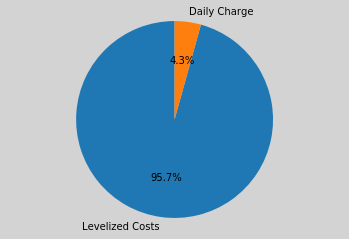

ERROR:ga_logger:panel values: (184.5019995086525, 151.54850222103147, 193.92449340922644, 16.343540316653083, 22.119683894827723, 12.245393068309655, 0.5485759164841884, 0.38248996957447656, 0.631740573593581)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 16.3
                                           and a gcr of 0.549


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.092052936553955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 152
                                           a tilt of 22.1
                                           and a gcr of 0.382


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4909958839416504 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 194
                                           a tilt of 12.2
                                           and a gcr of 0.632


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4243597984313965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 179 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [243.25651009807757, 59.41177010662643, 0.0]


ERROR:ga_logger:Cost: 3139.2183261708924


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


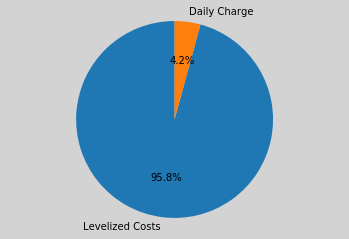

ERROR:ga_logger:panel values: (90.0000000001279, 90.00000000007914, 115.41562175252862, 13.525047443354735, 55.99999999989068, 31.001562285731186, 0.2990355725941284, 0.20000000000014087, 0.675756045390829)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 13.5
                                           and a gcr of 0.299


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.522507905960083 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.902106523513794 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 31.0
                                           and a gcr of 0.676


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4801125526428223 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 180 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [45.65773076682137, 0.0, 301.44017923931943]


ERROR:ga_logger:Cost: 3580.502291071591


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


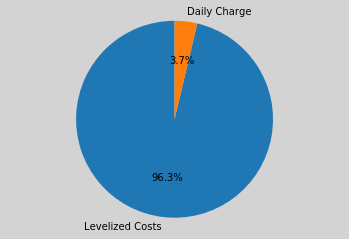

ERROR:ga_logger:panel values: (156.53631579373638, 180.07091324133125, 168.77667881979426, 25.349321856567535, 31.225300427473105, 21.110428069015352, 0.6616966407383053, 0.49424172386801635, 0.5467764529251864)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.3
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.43358039855957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.2
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4707446098327637 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.547


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4035308361053467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 180 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 293.9345288405175, 0.0]


ERROR:ga_logger:Cost: 3052.472973578682


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


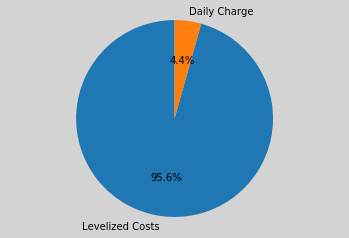

ERROR:ga_logger:panel values: (156.69203551901035, 179.84879040446702, 168.61967723669784, 25.386441627545096, 31.025284850542924, 21.056670648730613, 0.6622826544288793, 0.4950723619602125, 0.5467920279247938)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.4
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.4732935428619385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.495


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.364710569381714 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.547


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4804844856262207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 177 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 295.2407860937066, 0.0]


ERROR:ga_logger:Cost: 3065.446981244842


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


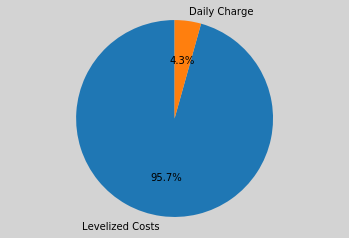

ERROR:ga_logger:panel values: (156.70763782145775, 180.01663490662182, 168.66249156931661, 25.451703176200414, 31.091430931060575, 21.038946892048614, 0.6618838412441985, 0.49552383651661736, 0.546076352659187)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.5
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.510003328323364 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.1
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.389552354812622 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.0
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4559507369995117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 293.95941685131277, 0.0]


ERROR:ga_logger:Cost: 3052.720166191201


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


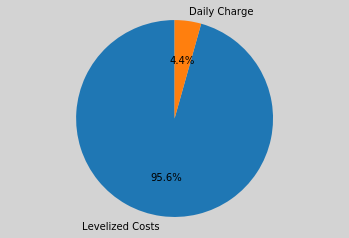

ERROR:ga_logger:panel values: (102.76939273387646, 249.27038129369538, 264.58877987952985, 45.981969989179994, 1.5405910692221911, 26.416524935624935, 0.8986650663709419, 0.6000999457484296, 0.8661248972588891)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 103
                                           a tilt of 46.0
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.859668254852295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 249
                                           a tilt of 1.5
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.187650442123413 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 26.4
                                           and a gcr of 0.866


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4806835651397705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 177 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 334.9840555225012, 0.0]


ERROR:ga_logger:Cost: 3460.185051672868


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


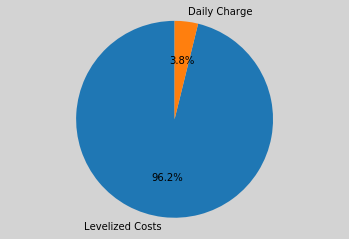

ERROR:ga_logger:panel values: (102.54057942727688, 239.98894706499186, 213.5652200305428, 6.1864258359828055, 17.085609628513527, 33.35105314378608, 0.8791413748128949, 0.6548735826911501, 0.7009514367543805)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 103
                                           a tilt of 6.2
                                           and a gcr of 0.879


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.502857685089111 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 17.1
                                           and a gcr of 0.655


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3322575092315674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 214
                                           a tilt of 33.4
                                           and a gcr of 0.701


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.410360813140869 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 172 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 321.81210051160247]


ERROR:ga_logger:Cost: 3329.358618355604


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


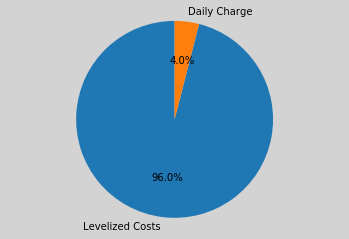

ERROR:ga_logger:panel values: (183.66595153945454, 222.605147418231, 155.00939086326738, 20.178061843317234, 18.730957663890702, 18.424371129552995, 0.8918988580836025, 0.8126431473109346, 0.6866448649610442)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 184
                                           a tilt of 20.2
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.574209690093994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 223
                                           a tilt of 18.7
                                           and a gcr of 0.813


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.874488592147827 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 18.4
                                           and a gcr of 0.687


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5628457069396973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 165 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 309.6117615261635]


ERROR:ga_logger:Cost: 3208.182371810767


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


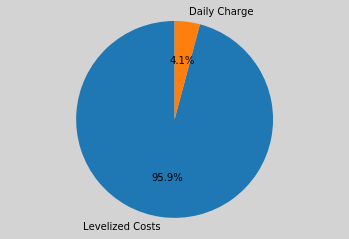

ERROR:ga_logger:panel values: (148.89865729488048, 170.42768297583928, 189.90615019940276, 19.757257283200556, 27.36167024981934, 20.961439094777674, 0.63928728240882, 0.4624469678649592, 0.6525037343449738)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 19.8
                                           and a gcr of 0.639


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.654260635375977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 27.4
                                           and a gcr of 0.462


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4783380031585693 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 21.0
                                           and a gcr of 0.653


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.65514874458313 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 167 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 227.81236576151687, 69.25538759560261]


ERROR:ga_logger:Cost: 3083.5927810486633


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


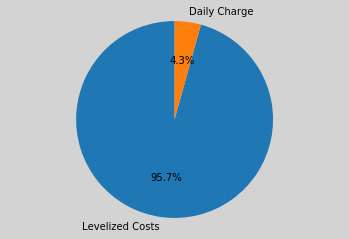

ERROR:ga_logger:panel values: (145.71052118174578, 178.36353370056253, 180.27257970660386, 24.75093703821521, 28.801422262889663, 29.455276272702825, 0.6064370536296669, 0.49441681741983795, 0.5716181129883064)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 146
                                           a tilt of 24.8
                                           and a gcr of 0.606


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.4911720752716064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 28.8
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.385258197784424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 29.5
                                           and a gcr of 0.572


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.923187255859375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 165 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 295.28309502013985, 0.0]


ERROR:ga_logger:Cost: 3065.8672001777472


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


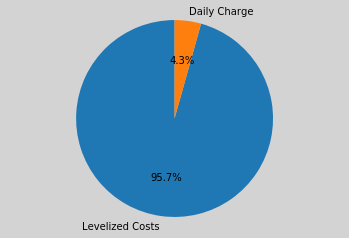

ERROR:ga_logger:panel values: (156.5266948058193, 180.54464374446715, 168.64488633329606, 25.411318853842893, 31.20299525320959, 21.014740412143862, 0.6618370668226339, 0.495398796017794, 0.5458525895648334)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.4
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.959368467330933 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 31.2
                                           and a gcr of 0.495


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.08031439781189 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.0
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.393974542617798 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 294.03000777925854, 0.0]


ERROR:ga_logger:Cost: 3053.4212894689526


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


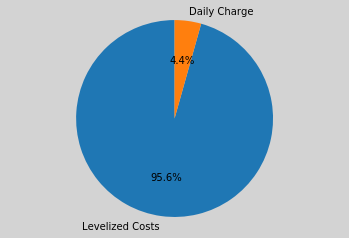

ERROR:ga_logger:panel values: (92.89506303390128, 115.41825214446612, 212.55670376340845, 53.83201471744468, 7.921041808913066, 54.962338230056716, 0.8925730267003675, 0.49814044288972364, 0.20217878789238505)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 93
                                           a tilt of 53.8
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.833993911743164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 7.9
                                           and a gcr of 0.498


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.43031644821167 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 213
                                           a tilt of 55.0
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6053028106689453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 298.26740904847645, 0.0]


ERROR:ga_logger:Cost: 3763.355368112026


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


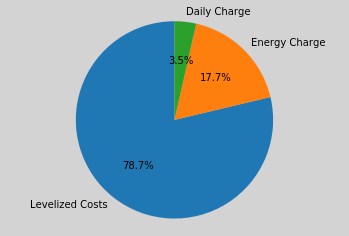

ERROR:ga_logger:panel values: (109.35045737468337, 104.85043518413657, 152.5129117783941, 28.100011964356987, 48.07355118393812, 23.851424616964085, 0.892887654823288, 0.5205203669584348, 0.8721634954676938)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 109
                                           a tilt of 28.1
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.662121295928955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 48.1
                                           and a gcr of 0.521


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.468581438064575 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 153
                                           a tilt of 23.9
                                           and a gcr of 0.872


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4572670459747314 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 326.55535182359466]


ERROR:ga_logger:Cost: 3376.46950467963


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


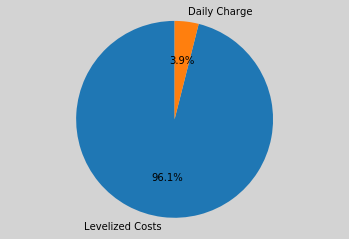

ERROR:ga_logger:panel values: (207.39922708805145, 174.91474712621766, 216.49756471496607, 42.366483891939914, 20.74994381543835, 23.036804478175736, 0.8902658604919382, 0.88805669000691, 0.8995020159863303)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 207
                                           a tilt of 42.4
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.6441662311553955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 20.7
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3709871768951416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 216
                                           a tilt of 23.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.53737735748291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 154 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 318.64948473296, 0.0]


ERROR:ga_logger:Cost: 3297.9468516950124


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


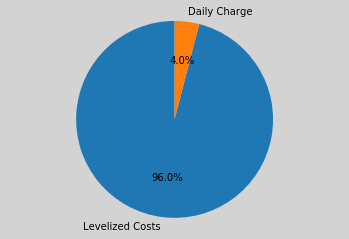

ERROR:ga_logger:panel values: (181.742192512707, 172.3525192699745, 177.46783165403616, 20.275403366003022, 22.208136905032454, 17.37130828085064, 0.7766569192555424, 0.5898453767737534, 0.5841726795680566)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 182
                                           a tilt of 20.3
                                           and a gcr of 0.777


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.463105916976929 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 172
                                           a tilt of 22.2
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.228835105895996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 17.4
                                           and a gcr of 0.584


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4603376388549805 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  18 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 300.5060762823106, 0.0]


ERROR:ga_logger:Cost: 3117.742889470996


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


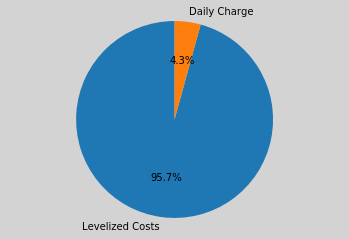

ERROR:ga_logger:panel values: (128.1653513155272, 205.86950412720398, 197.604273581496, 34.15863650316777, 40.11520625540536, 12.257994172834213, 0.7666597431047009, 0.6011414028830082, 0.43242052253018093)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 128
                                           a tilt of 34.2
                                           and a gcr of 0.767


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.670908689498901 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 206
                                           a tilt of 40.1
                                           and a gcr of 0.601


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4973719120025635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 12.3
                                           and a gcr of 0.432


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3972361087799072 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 190.54655587872995, 121.85051677381287]


ERROR:ga_logger:Cost: 3235.846646519908


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (264.99999999999056, 264.99999999998664, 90.00000000007739, 43.90512467772783, 14.444285423985574, 55.99999999998361, 0.20000000000002863, 0.8999999999631105, 0.8999999999999666)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 43.9
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.324748992919922 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 14.4
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.467057466506958 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.429147481918335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 363.919210342675, 0.0]


ERROR:ga_logger:Cost: 3747.574797042996


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (168.45912161890777, 221.263817644963, 254.4128373979712, 12.497968685557067, 55.23573374532712, 48.4328351300647, 0.8682369670130028, 0.8787721322475117, 0.21127878538460557)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 12.5
                                           and a gcr of 0.868


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.7341148853302 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 221
                                           a tilt of 55.2
                                           and a gcr of 0.879


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3702070713043213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 254
                                           a tilt of 48.4
                                           and a gcr of 0.211


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.40287709236145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 157 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [319.23940723976244, 0.0, 0.0]


ERROR:ga_logger:Cost: 3303.8060701405307


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (151.36906670719242, 164.58158166726395, 218.44986383579996, 1.7780090394413124, 46.433643925919675, 31.660464059231025, 0.898218541270219, 0.6909900296847532, 0.3764449346805464)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 151
                                           a tilt of 1.8
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.6734888553619385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 46.4
                                           and a gcr of 0.691


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.473975419998169 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 218
                                           a tilt of 31.7
                                           and a gcr of 0.376


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4692957401275635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 199.29605884972162, 116.82616465382195]


ERROR:ga_logger:Cost: 3272.8455991901164


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


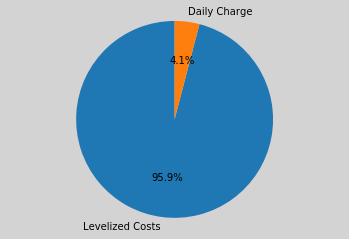

ERROR:ga_logger:panel values: (144.75942101741455, 234.63860733665578, 190.8549756547655, 13.93754569512748, 32.009895688252556, 51.605905038531326, 0.8836415052456288, 0.6838103057835669, 0.4138535397125479)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 13.9
                                           and a gcr of 0.884


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.651602268218994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 32.0
                                           and a gcr of 0.684


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3298327922821045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 51.6
                                           and a gcr of 0.414


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5449798107147217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 159 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [127.82205431933257, 0.0, 187.9341761680112]


ERROR:ga_logger:Cost: 3269.2104785121132


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


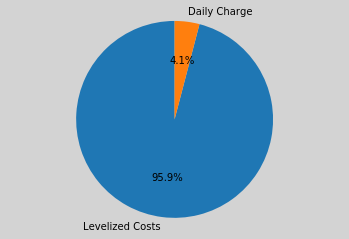

ERROR:ga_logger:panel values: (138.05372307552736, 184.7288566443492, 179.6625372390601, 21.20340743927281, 33.19051365007812, 26.461238606163622, 0.6688293460505527, 0.49934854381204385, 0.561870893966526)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 138
                                           a tilt of 21.2
                                           and a gcr of 0.669


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.707154750823975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 33.2
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3705966472625732 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 26.5
                                           and a gcr of 0.562


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4294681549072266 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 295.0468336879845, 0.0]


ERROR:ga_logger:Cost: 3063.5206091275877


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (136.7544868331959, 175.61032694781397, 180.53216109942187, 25.38699559236125, 31.824699707320356, 28.57021251927374, 0.610889293515849, 0.4621158241978201, 0.5733398155841081)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 25.4
                                           and a gcr of 0.611


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.656116962432861 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 31.8
                                           and a gcr of 0.462


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.324099540710449 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 28.6
                                           and a gcr of 0.573

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.30684757232666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 180 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 200.52431501469326, 94.50655646647219]


ERROR:ga_logger:Cost: 3063.362067267598


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (156.521395552923, 180.31775154845542, 168.72849620460522, 25.36554179806975, 31.228153477790475, 21.07572179416944, 0.6619560801739579, 0.49452107559909697, 0.5465230316864857)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.4
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.695147514343262 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.2
                                           and a gcr of 0.495


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4258668422698975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.547


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3762056827545166 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 177 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 293.97552497223853, 0.0]


ERROR:ga_logger:Cost: 3052.88015535274


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (156.24142650290048, 180.07085116109954, 169.29812508675158, 25.34946824729989, 31.163179214870922, 21.107327613116787, 0.6621618230593307, 0.4936388852819892, 0.5452673601314655)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.3
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.674068927764893 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.2
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5609896183013916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3776307106018066 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 189 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 293.91864261256774, 0.0]


ERROR:ga_logger:Cost: 3052.3151883282


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


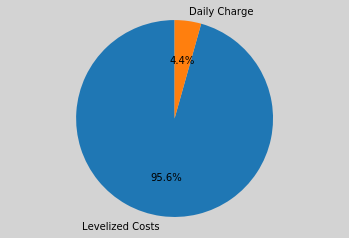

ERROR:ga_logger:panel values: (156.46790324323962, 179.9309109956605, 168.5862558076546, 25.35852310667063, 31.26292282952295, 21.08557334881565, 0.6621751417800755, 0.493822158229985, 0.5460085371423062)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.4
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.81236457824707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.3
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.36262583732605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.34905743598938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 184 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 295.2154418214847, 0.0]


ERROR:ga_logger:Cost: 3065.1952570372437


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


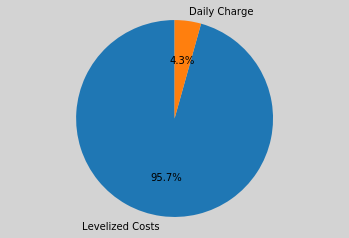

ERROR:ga_logger:panel values: (156.68988631905142, 180.08968277884242, 168.8202484857978, 25.33112268057971, 31.22841612991554, 21.100329412488886, 0.6615838264723974, 0.4940760222705463, 0.5465498994012183)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 25.3
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.737979888916016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.2
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.075821161270142 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.547


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3493387699127197 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 183 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 293.9328353227108, 0.0]


ERROR:ga_logger:Cost: 3052.4561532206835


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


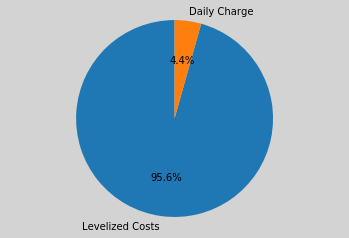

ERROR:ga_logger:panel values: (103.55106193490744, 178.7181631510818, 257.2353808253821, 55.535857799836066, 6.808218147668403, 49.87186462663693, 0.49573258409877763, 0.8591178696155235, 0.5644091196049814)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 104
                                           a tilt of 55.5
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.970683336257935 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 6.8
                                           and a gcr of 0.859


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9422028064727783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 257
                                           a tilt of 49.9
                                           and a gcr of 0.564


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4921319484710693 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 322.27720983441105, 0.0]


ERROR:ga_logger:Cost: 3333.9781264521257


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


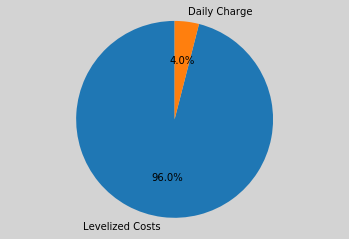

ERROR:ga_logger:panel values: (122.1690180232161, 127.11472360461211, 175.39039636705343, 4.549332523798835, 45.433016658691294, 11.07075487609673, 0.8743447774485409, 0.47250665268206676, 0.6184619061590833)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 122
                                           a tilt of 4.5
                                           and a gcr of 0.874


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.776676893234253 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 127
                                           a tilt of 45.4
                                           and a gcr of 0.473


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3971879482269287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 11.1
                                           and a gcr of 0.618


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.476361036300659 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 168 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.2755856970198]


ERROR:ga_logger:Cost: 3224.707799750952


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


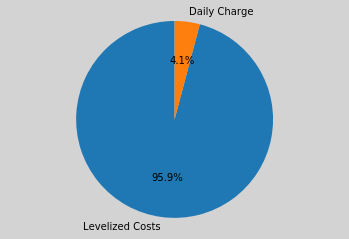

ERROR:ga_logger:panel values: (130.44610980870573, 211.2660139903556, 214.0962997066425, 31.778330568047558, 10.184107160295817, 45.02652279674491, 0.7417806670883902, 0.8986735772789396, 0.7580781122598772)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 31.8
                                           and a gcr of 0.742


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.8625853061676025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 211
                                           a tilt of 10.2
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5269949436187744 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 214
                                           a tilt of 45.0
                                           and a gcr of 0.758


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4303183555603027 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 326.88056330859104, 0.0]


ERROR:ga_logger:Cost: 3379.6995561087474


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


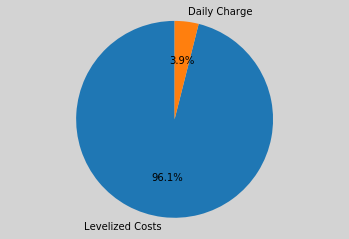

ERROR:ga_logger:panel values: (143.17999349264488, 178.591625824404, 172.4444843520737, 28.849569651181046, 30.495002229418063, 22.25767432978088, 0.6311772537231455, 0.4870101003746591, 0.5941846992874844)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 143
                                           a tilt of 28.8
                                           and a gcr of 0.631


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.798633098602295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 30.5
                                           and a gcr of 0.487


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.360999822616577 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 22.3
                                           and a gcr of 0.594


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.34143328666687 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 274.5160909931098, 20.847148409911625]


ERROR:ga_logger:Cost: 3066.6632110560067


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (165.16712193167547, 152.25990049898456, 141.05184587905927, 16.333694913211808, 22.438462559626533, 13.376686454164625, 0.5486796671601288, 0.38229373610104067, 0.43125431228520505)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 16.3
                                           and a gcr of 0.549


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.929204940795898 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 152
                                           a tilt of 22.4
                                           and a gcr of 0.382


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.532087564468384 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 141
                                           a tilt of 13.4
                                           and a gcr of 0.431


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.454369068145752 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [246.55208546347973, 57.117145241698374, 0.0]


ERROR:ga_logger:Cost: 3149.15996630924


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


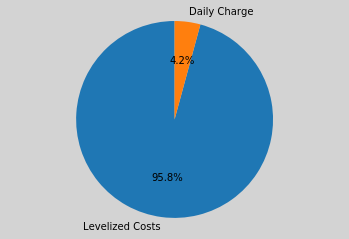

ERROR:ga_logger:panel values: (222.11658094110615, 249.09055527411948, 264.99999999696036, 7.977190849629278, 55.99999999940791, 19.27002445238549, 0.8706703069608457, 0.2000000000033367, 0.2000000000117651)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 222
                                           a tilt of 8.0
                                           and a gcr of 0.871


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.936734914779663 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 249
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.088857173919678 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 19.3
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.729016304016113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [328.13338337047674, 0.0, 0.0]


ERROR:ga_logger:Cost: 3392.1428120861747


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


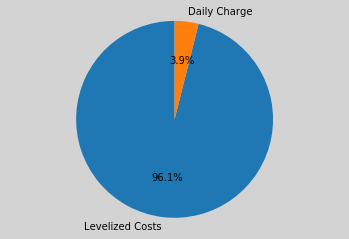

ERROR:ga_logger:panel values: (261.0529802640024, 261.02638977335016, 264.5063408431338, 4.7471635584467515, 54.476049676451986, 1.7390498217555663, 0.8851991445382956, 0.8726572590121153, 0.6661703889881723)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 4.7
                                           and a gcr of 0.885


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.13353157043457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 54.5
                                           and a gcr of 0.873


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.423970937728882 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 1.7
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.950542449951172 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.1820129620456]


ERROR:ga_logger:Cost: 3472.083404220523


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


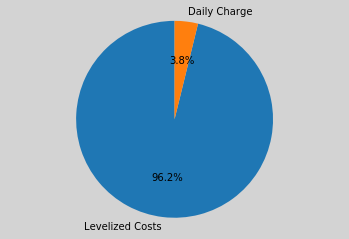

ERROR:ga_logger:panel values: (151.6191466475084, 206.59853851032256, 264.6027799253418, 2.455903117158519, 34.27842966488434, 4.267550407061997, 0.8917210565052422, 0.42018691614255743, 0.526061004238372)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 2.5
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.610782623291016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 207
                                           a tilt of 34.3
                                           and a gcr of 0.420


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3675103187561035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 4.3
                                           and a gcr of 0.526


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.560638189315796 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 154 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [112.83113379375924, 198.42478760120088, 0.0]


ERROR:ga_logger:Cost: 3224.512497620753


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


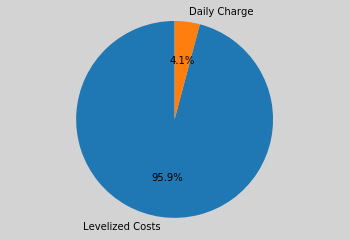

ERROR:ga_logger:panel values: (155.56588896575755, 156.6230842598594, 197.93183643224495, 12.69167125935211, 29.763407715631317, 16.937151658423055, 0.8721662621797386, 0.3039449320243095, 0.4459807907790908)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 12.7
                                           and a gcr of 0.872


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.980032205581665 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 157
                                           a tilt of 29.8
                                           and a gcr of 0.304


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.417804002761841 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 16.9
                                           and a gcr of 0.446


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.420588493347168 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  17 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 160 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [85.51399458421831, 0.0, 223.30876688223938]


ERROR:ga_logger:Cost: 3200.3458626515576


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (161.73851738644515, 169.31438353145575, 173.35436917028392, 19.736020670407356, 24.977035500511555, 14.89488798264881, 0.6317608874918312, 0.4201054919991848, 0.5487661710321206)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 162
                                           a tilt of 19.7
                                           and a gcr of 0.632


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.188905954360962 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 25.0
                                           and a gcr of 0.420


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.296095848083496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 14.9
                                           and a gcr of 0.549


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3135266304016113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 159 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [144.27152891315401, 155.60604316383782, 0.0]


ERROR:ga_logger:Cost: 3111.500459273992


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (183.30128035685044, 190.3502865252877, 198.0812464494423, 34.15816470981473, 39.817237497290066, 29.883547618351958, 0.7758873984715267, 0.37995001996729083, 0.6491165278356656)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 34.2
                                           and a gcr of 0.776


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.9396278858184814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 39.8
                                           and a gcr of 0.380


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4038240909576416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 29.9
                                           and a gcr of 0.649


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4947855472564697 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [6.666733334000007e-06, 123.60284442221419, 177.49977343251496]


ERROR:ga_logger:Cost: 3123.6679344303343


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


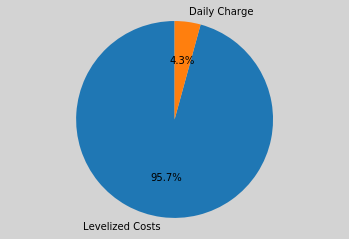

ERROR:ga_logger:panel values: (90.00000000002575, 180.50692451565635, 90.0000000000664, 1.0000000000311757, 22.155690089521073, 55.999999999976346, 0.3980504572980147, 0.6274020520662988, 0.5351907159639184)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.398


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9508700370788574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 22.2
                                           and a gcr of 0.627


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.498914957046509 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.407280206680298 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 299.9407823751644, 0.0]


ERROR:ga_logger:Cost: 3112.128278262116


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (91.53615106156245, 260.7880792113199, 133.46737387083, 1.987061557487926, 53.074951787945075, 54.31230536876449, 0.5110398490930185, 0.888619986611979, 0.8928573764023446)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 2.0
                                           and a gcr of 0.511


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.668665885925293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 53.1
                                           and a gcr of 0.889


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4626078605651855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 133
                                           a tilt of 54.3
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4638280868530273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [242.00202819919053, 0.0, 111.797732192489]


ERROR:ga_logger:Cost: 3647.0664057905733


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


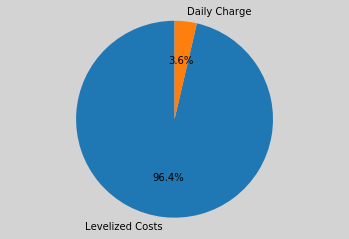

ERROR:ga_logger:panel values: (93.81824849256569, 174.77633850796153, 109.39104445756644, 2.845487281212954, 14.685556615270055, 30.74091032011021, 0.8033526687374317, 0.7898381014185336, 0.46671464370976923)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 94
                                           a tilt of 2.8
                                           and a gcr of 0.803


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.1101367473602295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 14.7
                                           and a gcr of 0.790


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3421595096588135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 109
                                           a tilt of 30.7
                                           and a gcr of 0.467


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.326051712036133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 312.46341086630656, 0.0]


ERROR:ga_logger:Cost: 3236.505521470977


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (98.45545595481815, 176.26644711103256, 132.71006938815648, 10.505981463144032, 31.926717290877946, 52.10488114527902, 0.7178422440744572, 0.5944281126141023, 0.5555786407808597)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 98
                                           a tilt of 10.5
                                           and a gcr of 0.718


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.9729697704315186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 31.9
                                           and a gcr of 0.594

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3903112411499023 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 133
                                           a tilt of 52.1
                                           and a gcr of 0.556


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4438059329986572 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 299.41076191146345, 0.0]


ERROR:ga_logger:Cost: 3106.8640168168095


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (129.83557632222409, 174.3821633716027, 162.0371217410975, 18.3669880463194, 27.62413918899743, 29.93418265222464, 0.6162622646257654, 0.5084322722204667, 0.565814801546997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 18.4
                                           and a gcr of 0.616


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.885791063308716 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 27.6
                                           and a gcr of 0.508


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.373818874359131 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 29.9
                                           and a gcr of 0.566


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3748302459716797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 165 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 296.06023033483, 0.0]


ERROR:ga_logger:Cost: 3073.58586261733


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (145.82205432868014, 161.78163747044852, 141.1654196729338, 34.09338106325557, 22.2243415581711, 12.45277595240045, 0.5552510202735079, 0.6031779864525062, 0.4373808838237211)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 146
                                           a tilt of 34.1
                                           and a gcr of 0.555


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.086351156234741 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 162
                                           a tilt of 22.2
                                           and a gcr of 0.603


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4180099964141846 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 141
                                           a tilt of 12.5
                                           and a gcr of 0.437


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.502939224243164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 169 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 302.9893251505787, 0.0]


ERROR:ga_logger:Cost: 3142.4070131612516


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


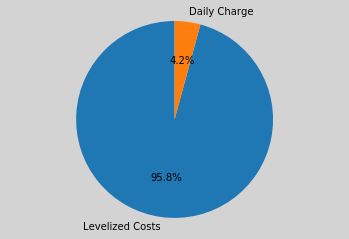

ERROR:ga_logger:panel values: (240.09945580965626, 90.00000000000387, 165.55004363932926, 2.72225187581214, 33.77239199537918, 30.307783273314165, 0.7701264939926833, 0.5756446877657315, 0.6747213230453939)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 2.7
                                           and a gcr of 0.770


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.803345441818237 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 33.8
                                           and a gcr of 0.576


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3655433654785156 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 30.3
                                           and a gcr of 0.675


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4366049766540527 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 166 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 306.0932454328503]


ERROR:ga_logger:Cost: 3173.2357781320693


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


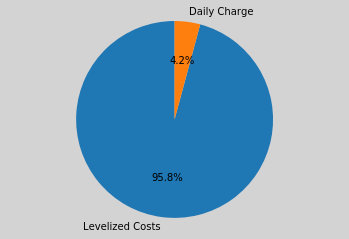

ERROR:ga_logger:panel values: (156.34324495948647, 180.40594680811603, 169.80672893497928, 25.33429538788081, 31.05558214945729, 21.18286468824726, 0.6608952666495153, 0.49477285370771584, 0.5475580877419031)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.3
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.315683603286743 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.1
                                           and a gcr of 0.495


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.467315912246704 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 21.2
                                           and a gcr of 0.548


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.382863759994507 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 293.9933766750681, 0.0]


ERROR:ga_logger:Cost: 3053.057461896751


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (156.3141276684475, 179.9872299678554, 169.42063324957775, 25.32330663922992, 31.223638786412796, 21.145221055218077, 0.6631019403876117, 0.4950379739049942, 0.5450317732973439)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.3
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.262173414230347 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.2
                                           and a gcr of 0.495


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4191296100616455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4485044479370117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 295.25229884566755, 0.0]


ERROR:ga_logger:Cost: 3065.5613283550156


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


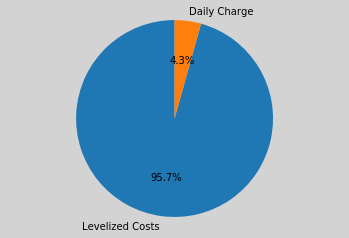

ERROR:ga_logger:panel values: (156.2853411867443, 180.12706788130077, 169.26594563208118, 25.384442463731116, 31.1646748593054, 21.170386212125358, 0.6620766066275359, 0.49351565080280924, 0.5449445864464455)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.4
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.051275014877319 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.2
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.727613925933838 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.2
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4323768615722656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 293.9230576290063, 0.0]


ERROR:ga_logger:Cost: 3052.3590391515922


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


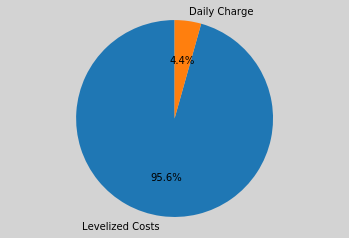

ERROR:ga_logger:panel values: (263.6216179598458, 150.09419804532658, 263.0172598283525, 3.379779200814174, 3.314463018595517, 11.1495276957156, 0.8979116767289346, 0.81910189048761, 0.237842581139608)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 3.4
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.230824947357178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 3.3
                                           and a gcr of 0.819


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.295731544494629 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 11.1
                                           and a gcr of 0.238


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.595011472702026 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 328.27948459498117, 0.0]


ERROR:ga_logger:Cost: 3393.5939149948263


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (242.20694757783838, 168.91391131701067, 260.30682831831257, 10.055325838310214, 39.74758996454457, 22.521191995007698, 0.8977559435629949, 0.6864205243503427, 0.7435595822223231)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 242
                                           a tilt of 10.1
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.737411975860596 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 39.7
                                           and a gcr of 0.686


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9600703716278076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 22.5
                                           and a gcr of 0.744


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4751296043395996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 311.75852993667326, 0.0]


ERROR:ga_logger:Cost: 3229.5045248991055


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


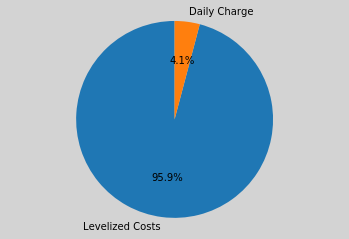

ERROR:ga_logger:panel values: (211.08732928315288, 154.1419831745028, 181.94538270848466, 3.2064635300446995, 34.65706615522694, 24.8113793864612, 0.8993829106491853, 0.6615946006856626, 0.5981561459151267)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 211
                                           a tilt of 3.2
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.4839863777160645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 34.7
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4020543098449707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 24.8
                                           and a gcr of 0.598


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4859352111816406 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 298.1686822260814]


ERROR:ga_logger:Cost: 3094.5274273647888


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (180.7568125433948, 171.01469813196871, 188.50750406399666, 22.20909443290916, 36.47639719653715, 26.31489573589584, 0.7720380670808755, 0.45823602910768146, 0.586452593577745)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 181
                                           a tilt of 22.2
                                           and a gcr of 0.772


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.984496116638184 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 36.5
                                           and a gcr of 0.458


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4405765533447266 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 189
                                           a tilt of 26.3
                                           and a gcr of 0.586


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5058822631835938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 155 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 193.46475161628948, 103.54825520322468]


ERROR:ga_logger:Cost: 3083.0490330072216


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (127.47818089237262, 201.56896538512478, 195.99407160510657, 34.19808977412072, 22.178393516276063, 12.866075483380754, 0.7717724219937512, 0.38371717372861436, 0.4308492981143096)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 127
                                           a tilt of 34.2
                                           and a gcr of 0.772


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.132699012756348 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 202
                                           a tilt of 22.2
                                           and a gcr of 0.384


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4003429412841797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 196
                                           a tilt of 12.9
                                           and a gcr of 0.431


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.478630542755127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [155.8381106258567, 0.0, 170.97794199294907]


ERROR:ga_logger:Cost: 3379.0588308115493


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


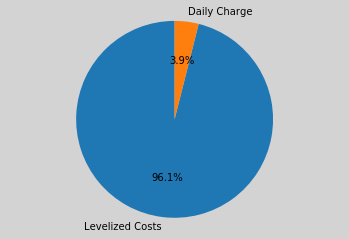

ERROR:ga_logger:panel values: (264.9999993912976, 90.00000046213493, 264.99999903308355, 1.0000019717817659, 1.0000003632096388, 1.0000001417392872, 0.20000000180877808, 0.8999999958725073, 0.3653919912810394)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.12615442276001 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3930299282073975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.365


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4067611694335938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 335.9895092416156, 0.0]


ERROR:ga_logger:Cost: 3470.171418839815


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


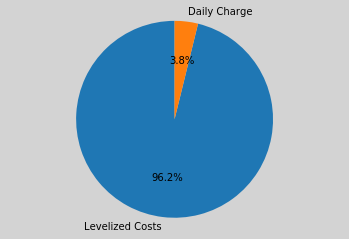

ERROR:ga_logger:panel values: (99.8939503122502, 183.9188333970398, 254.22340808266637, 8.793184892967563, 1.5467334826850196, 22.415441998545056, 0.2928965153323744, 0.8881903500089217, 0.32888303784599177)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 8.8
                                           and a gcr of 0.293


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.09345269203186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 1.5
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2029216289520264 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 254
                                           a tilt of 22.4
                                           and a gcr of 0.329


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3701488971710205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 155 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [98.51334429830331, 233.0787966613658, 0.0]


ERROR:ga_logger:Cost: 3426.4958791364816


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (131.03228399160025, 179.78242575471074, 178.18240699239232, 11.971339602983559, 2.759986259435707, 49.51111811494861, 0.5220028964554084, 0.8279744117970325, 0.39810304797941537)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 131
                                           a tilt of 12.0
                                           and a gcr of 0.522


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.300741910934448 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 2.8
                                           and a gcr of 0.828


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1971487998962402 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 49.5
                                           and a gcr of 0.398


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4003002643585205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 147.83546916232262, 167.2872443451064]


ERROR:ga_logger:Cost: 3262.918253979345


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


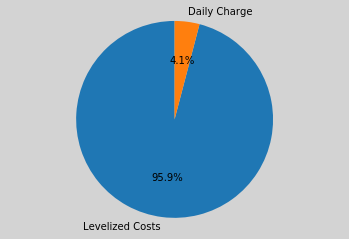

ERROR:ga_logger:panel values: (151.3554569081009, 180.406675559522, 157.50165945986367, 4.993677829615185, 22.251059150970605, 39.92736842815109, 0.712246450340593, 0.721393555380142, 0.4788356683958264)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 151
                                           a tilt of 5.0
                                           and a gcr of 0.712


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.205222129821777 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 22.3
                                           and a gcr of 0.721


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.815032720565796 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 158
                                           a tilt of 39.9
                                           and a gcr of 0.479


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.430938720703125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 170 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 49.99366839727315, 253.52441116926525]


ERROR:ga_logger:Cost: 3147.658718114874


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (157.7337421608052, 170.90980091910654, 165.24115319758596, 18.109777553363262, 31.07148076133756, 29.95768763415065, 0.6716318452157013, 0.481912075037152, 0.5918871066491771)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 18.1
                                           and a gcr of 0.672


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.711528778076172 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 31.1
                                           and a gcr of 0.482


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.48447322845459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 30.0
                                           and a gcr of 0.592


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.407106876373291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 168 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 254.5833935284517, 41.71857083145283]


ERROR:ga_logger:Cost: 3075.986815572357


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (160.26677327423678, 176.1357838955394, 196.7774949632868, 34.047261115618, 28.08674604565904, 12.121985254896648, 0.5482831500724442, 0.38534317751629876, 0.4415601582982171)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 34.0
                                           and a gcr of 0.548


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.263685464859009 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 28.1
                                           and a gcr of 0.385


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5999794006347656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 12.1
                                           and a gcr of 0.442


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5204474925994873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [233.74037276514613, 66.45182562940727, 0.0]


ERROR:ga_logger:Cost: 3114.6253987150526


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


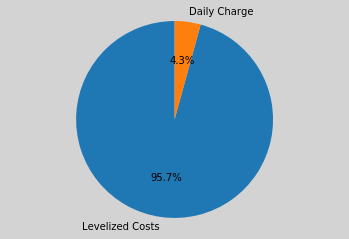

ERROR:ga_logger:panel values: (225.69529039795398, 264.9999999998437, 92.65825660907163, 1.0000000002787253, 40.73073672040959, 55.999999999281954, 0.2000000000051373, 0.4370121183896833, 0.20000000000226736)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 226
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.251708030700684 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 40.7
                                           and a gcr of 0.437


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.428938627243042 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.437826156616211 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 160 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 261.6661107035788, 0.0]


ERROR:ga_logger:Cost: 5206.098540988535


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


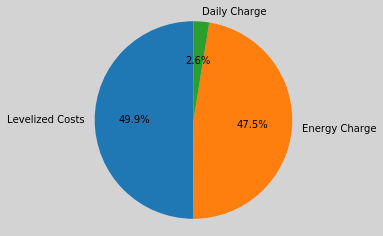

ERROR:ga_logger:panel values: (91.04009688935096, 136.71816385759593, 152.07980638717618, 1.5258254979465744, 1.7267919849494253, 3.844042156098471, 0.3754482610430212, 0.8960880898178827, 0.8408625968345749)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 1.5
                                           and a gcr of 0.375


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.088570594787598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 137
                                           a tilt of 1.7
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.29435658454895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 152
                                           a tilt of 3.8
                                           and a gcr of 0.841


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3761680126190186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 154 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 327.3906295960701]


ERROR:ga_logger:Cost: 3384.7656300501817


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (91.47969973947107, 105.03458570352892, 107.28997531841522, 30.475094747029168, 1.0838635316501697, 19.035845476389017, 0.8101438062717137, 0.8942218487852438, 0.8541999921492744)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 30.5
                                           and a gcr of 0.810


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.246283054351807 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 1.1
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4661548137664795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 107
                                           a tilt of 19.0
                                           and a gcr of 0.854


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.511894941329956 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 335.16353529201024, 0.0]


ERROR:ga_logger:Cost: 3461.967680630207


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


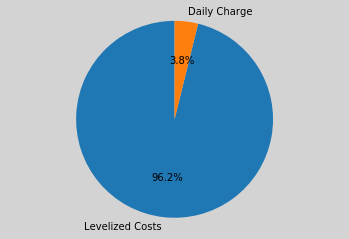

ERROR:ga_logger:panel values: (93.82269498612308, 146.87400181031555, 173.40907502329702, 11.872098607093406, 6.221801796155098, 26.226256745879788, 0.5611353981150207, 0.7684185279460896, 0.6594986593472958)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 94
                                           a tilt of 11.9
                                           and a gcr of 0.561


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.3394904136657715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 147
                                           a tilt of 6.2
                                           and a gcr of 0.768


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3732380867004395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 26.2
                                           and a gcr of 0.659


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3736190795898438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 154 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 302.3649506887837]


ERROR:ga_logger:Cost: 3136.205606152216


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (141.1615360681747, 163.3317094443098, 161.83921513879443, 25.68270650989525, 23.274203265096652, 27.081152688422254, 0.5993282619602569, 0.5760903814140763, 0.5564999481649839)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 141
                                           a tilt of 25.7
                                           and a gcr of 0.599


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.184449911117554 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 23.3
                                           and a gcr of 0.576


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.358414649963379 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 27.1
                                           and a gcr of 0.556


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3599636554718018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 155 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 300.44262885318113]


ERROR:ga_logger:Cost: 3117.1127200646133


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


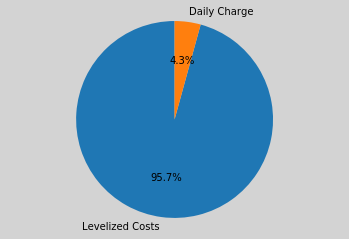

ERROR:ga_logger:panel values: (128.1673218585847, 199.93908182390317, 140.80657333799635, 16.36931155009971, 22.789636683355297, 12.238974676359392, 0.775113622815246, 0.5147074363993673, 0.4323394480404684)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 128
                                           a tilt of 16.4
                                           and a gcr of 0.775


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.342550039291382 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 22.8
                                           and a gcr of 0.515


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4225564002990723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 141
                                           a tilt of 12.2
                                           and a gcr of 0.432


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3665645122528076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 161 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 301.2649214137537, 0.0]


ERROR:ga_logger:Cost: 3125.2798900151906


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


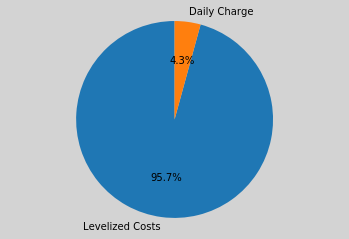

ERROR:ga_logger:panel values: (155.81059348518494, 133.69779417076018, 253.15204028532432, 26.26448883894279, 12.500361848362175, 37.89106407031866, 0.2000000003451983, 0.3385226827557868, 0.8999999999895689)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 26.3
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.248203277587891 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 134
                                           a tilt of 12.5
                                           and a gcr of 0.339


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.360896587371826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 253
                                           a tilt of 37.9
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3960375785827637 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 91.00395965692181, 296.94141931526354]


ERROR:ga_logger:Cost: 3986.2075209113236


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (156.03320506597572, 180.20320712317047, 169.04757915247694, 25.15802425725075, 31.11610079019013, 21.175334054156085, 0.6613354873764314, 0.4941019613936301, 0.5443811960936381)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.2
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.355787515640259 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.1
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6058037281036377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.2
                                           and a gcr of 0.544


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9847054481506348 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  17 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 169 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 293.94819873823656, 0.0]


ERROR:ga_logger:Cost: 3052.6087456418704


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (156.18377411620236, 180.02662015704465, 169.34463840617883, 25.37977817628125, 31.20858241109318, 21.08195895059102, 0.6609504720544892, 0.49418773233746077, 0.5448181457814971)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.4
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.7174458503723145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.2
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4704842567443848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.42453932762146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 164 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 293.9270711707012, 0.0]


ERROR:ga_logger:Cost: 3052.398902498482


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (156.240967403929, 180.1431832390499, 169.35028283756066, 25.353636488441886, 31.13173886705844, 21.10979948043867, 0.661746252187722, 0.49348221733665143, 0.5456924605039661)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.4
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.4812846183776855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.1
                                           and a gcr of 0.493


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5483829975128174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5382490158081055 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 161 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 293.92426343710514, 0.0]


ERROR:ga_logger:Cost: 3052.37101545134


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


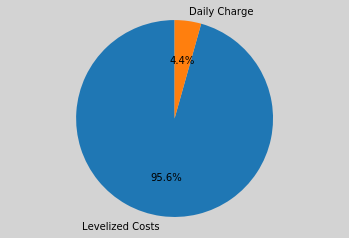

ERROR:ga_logger:panel values: (106.03292652301306, 262.7528451972019, 262.2771355667534, 17.06621438554753, 5.465452728536327, 4.231311627725026, 0.40434400600820886, 0.8945547263770321, 0.8915231158008927)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 106
                                           a tilt of 17.1
                                           and a gcr of 0.404


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.465116739273071 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 5.5
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.039496898651123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 262
                                           a tilt of 4.2
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.447733163833618 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 157 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [166.45953729408203, 0.0, 166.78941403920618]


ERROR:ga_logger:Cost: 3442.9516528688346


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


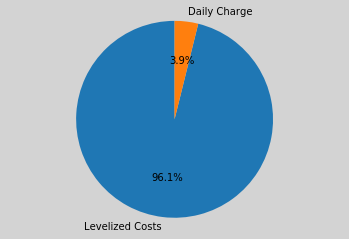

ERROR:ga_logger:panel values: (263.0823130762632, 98.36859370214087, 253.36834159717012, 14.572649762851757, 14.26606198327905, 2.349078134411117, 0.8823282891712865, 0.8928574636969879, 0.7298728131480856)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 14.6
                                           and a gcr of 0.882


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7151505947113037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 98
                                           a tilt of 14.3
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.39579701423645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 253
                                           a tilt of 2.3
                                           and a gcr of 0.730


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2669591903686523 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 334.90897400841044]


ERROR:ga_logger:Cost: 3459.439327184556


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


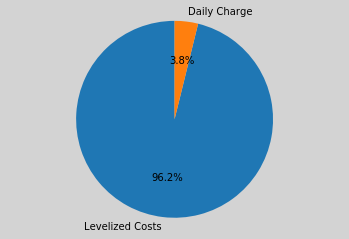

ERROR:ga_logger:panel values: (155.259481357724, 187.84879667467237, 172.31090311524497, 11.297066850074906, 3.6620197424952536, 9.96853824376371, 0.6337228029139557, 0.8150199967272043, 0.493778603703311)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 11.3
                                           and a gcr of 0.634


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.390716552734375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 3.7
                                           and a gcr of 0.815


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.396135568618774 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 10.0
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4105968475341797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 154 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [75.77266552975202, 0.0, 236.61582254971955]


ERROR:ga_logger:Cost: 3235.76136753111


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


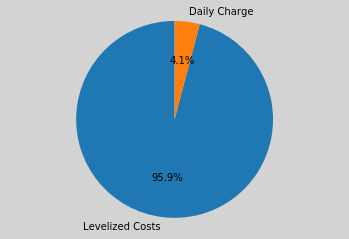

ERROR:ga_logger:panel values: (159.4616981356133, 176.5959966896757, 180.52799882622685, 25.094050238083206, 33.9228018967481, 29.947132828282232, 0.6702420458577298, 0.4773007535760843, 0.5698731007795093)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 159
                                           a tilt of 25.1
                                           and a gcr of 0.670


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.335111379623413 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 33.9
                                           and a gcr of 0.477


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.390023708343506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 29.9
                                           and a gcr of 0.570


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.376845359802246 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 161 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 236.27199600555872, 59.12129255953144]


ERROR:ga_logger:Cost: 3066.9616679555484


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


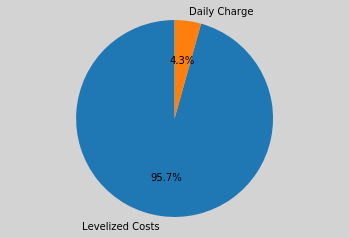

ERROR:ga_logger:panel values: (183.2383183855136, 155.21605352882943, 141.3392999893396, 33.79308689750009, 39.65906546503049, 30.14379979391917, 0.7774334329332513, 0.3794793267087311, 0.6527379004924003)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 33.8
                                           and a gcr of 0.777


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.345259428024292 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 39.7
                                           and a gcr of 0.379


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.42366623878479 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 141
                                           a tilt of 30.1
                                           and a gcr of 0.653


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3412325382232666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 166 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [151.1842211085373, 153.4219255469189, 0.0]


ERROR:ga_logger:Cost: 3158.4656197999257


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


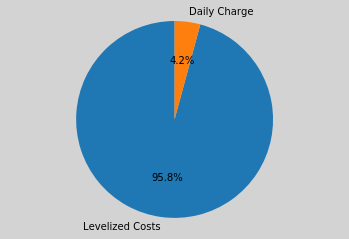

ERROR:ga_logger:panel values: (90.0000022339957, 90.0000001701728, 90.00000030957635, 55.99999957396935, 55.99999987470885, 55.99999972425853, 0.20000000061615714, 0.8999999992986578, 0.8999999975062127)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3380424976348877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3027045726776123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5780701637268066 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 170 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [8.876560736458628e-14, 0.0, 538.885511568748]


ERROR:ga_logger:Cost: 5621.955438467737


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


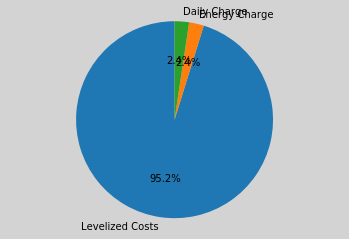

ERROR:ga_logger:panel values: (156.41127242238247, 179.84889239843693, 169.14211967168876, 25.40494906064204, 30.990645582034535, 21.07320466041216, 0.6621919852107007, 0.49488708843685864, 0.5445473359951891)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.4
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.320066452026367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.495


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8689944744110107 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5220556259155273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 172 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 295.23316032611956, 0.0]


ERROR:ga_logger:Cost: 3065.3712405669226


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


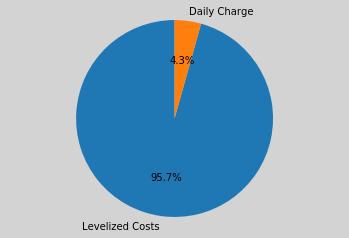

ERROR:ga_logger:panel values: (156.14655325037492, 180.08039512814594, 169.1791561765126, 25.35235620011969, 31.193273695219478, 21.08233429504343, 0.6619224495112546, 0.49237043883361564, 0.5451295405681089)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.4
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3702733516693115 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.2
                                           and a gcr of 0.492


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4346206188201904 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5250630378723145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 172 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 293.88775914460007, 0.0]


ERROR:ga_logger:Cost: 3052.008447555156


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


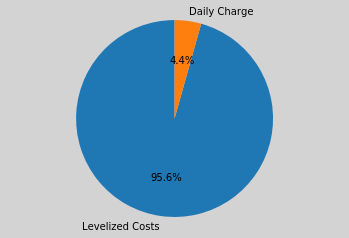

ERROR:ga_logger:panel values: (156.23042486660432, 180.22896859390937, 169.26841389740792, 25.35955638039829, 31.165082711401723, 21.085280152065287, 0.6623082229869071, 0.49378440403489887, 0.5451186742880401)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.4
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.028041839599609 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.2
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.355268955230713 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.336153984069824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 177 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 293.9437878987042, 0.0]


ERROR:ga_logger:Cost: 3052.564936335402


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


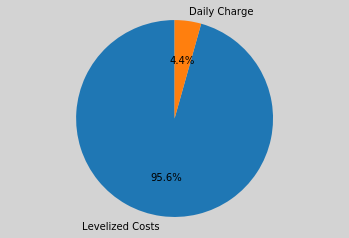

ERROR:ga_logger:panel values: (231.44300643349635, 263.0744531418349, 112.39056334859927, 55.730877091115666, 4.072760659803213, 1.5235378410056297, 0.883534531140064, 0.20754119345824765, 0.8597728530381834)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 231
                                           a tilt of 55.7
                                           and a gcr of 0.884


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3545706272125244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 4.1
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.345773935317993 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 112
                                           a tilt of 1.5
                                           and a gcr of 0.860


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.318155288696289 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 171 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 334.222137616846]


ERROR:ga_logger:Cost: 3452.6175309570303


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


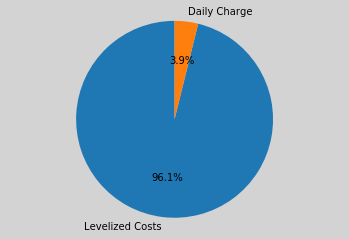

ERROR:ga_logger:panel values: (95.68370584130345, 251.61652956016815, 106.2461224559028, 53.44457540999306, 1.0005684697601631, 2.5974471509364814, 0.8079235300916974, 0.6060820390550965, 0.879327157899829)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 96
                                           a tilt of 53.4
                                           and a gcr of 0.808


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.682741641998291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 252
                                           a tilt of 1.0
                                           and a gcr of 0.606


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4124598503112793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 106
                                           a tilt of 2.6
                                           and a gcr of 0.879


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.250419855117798 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 161 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 334.2314753020561]


ERROR:ga_logger:Cost: 3452.7102749899013


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (91.96247273148354, 145.12811049125892, 150.374090469707, 3.330338054431193, 24.401007517529642, 29.386771654347825, 0.8437373668414401, 0.5599804468157127, 0.8253580573941437)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 3.3
                                           and a gcr of 0.844


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8764917850494385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 24.4
                                           and a gcr of 0.560


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6415927410125732 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 29.4
                                           and a gcr of 0.825


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.548741340637207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 307.61472095608156, 0.0]


ERROR:ga_logger:Cost: 3188.3473683893226


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (128.9727252960629, 174.26286467414917, 143.57625120929873, 17.305341764956914, 32.347398896868405, 29.115479805181078, 0.726657966227289, 0.4836571936824694, 0.6016462717234097)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 129
                                           a tilt of 17.3
                                           and a gcr of 0.727


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.248587608337402 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 32.3
                                           and a gcr of 0.484


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4323906898498535 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 144
                                           a tilt of 29.1
                                           and a gcr of 0.602


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4409193992614746 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [23.117736472695583, 274.2084309823047, 0.0]


ERROR:ga_logger:Cost: 3086.159405478491


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (144.72030396589795, 180.06362788547636, 176.06286734329296, 26.34622878920701, 30.259692494866492, 28.0425926614745, 0.6103092173436574, 0.4635983518565206, 0.5486436525284633)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 26.3
                                           and a gcr of 0.610


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.178906440734863 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 30.3
                                           and a gcr of 0.464


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7723498344421387 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 28.0
                                           and a gcr of 0.549


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.416250228881836 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 184.19263306854708, 110.52474605614145]


ERROR:ga_logger:Cost: 3060.248397491622


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


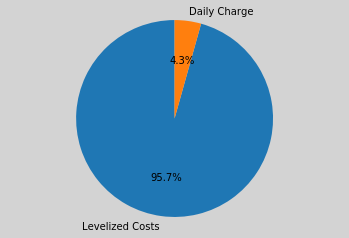

ERROR:ga_logger:panel values: (156.31449195847, 180.98876720913694, 169.22604777679962, 25.3065264785456, 31.159480092172785, 21.09136899887462, 0.6597737353520954, 0.4934286639701163, 0.5461330630681847)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.3
                                           and a gcr of 0.660


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.073544025421143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 31.2
                                           and a gcr of 0.493


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4637627601623535 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4311110973358154 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 294.0438213763652, 0.0]


ERROR:ga_logger:Cost: 3053.558488796668


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


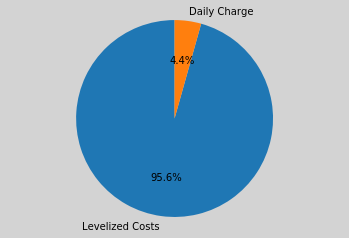

ERROR:ga_logger:panel values: (155.9649864217258, 180.19972059373822, 168.96949967394664, 25.187531742252016, 31.15558812646219, 21.14133770405696, 0.6612026597036998, 0.49273655053521254, 0.544398315818959)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.2
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.532485008239746 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.2
                                           and a gcr of 0.493


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4450175762176514 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.544


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4021942615509033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 293.9130125472125, 0.0]


ERROR:ga_logger:Cost: 3052.2592693697898


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (156.4326498832254, 180.0999505543728, 169.2391836142013, 25.32303465726127, 31.188806006547672, 21.059839023735307, 0.6617036733589154, 0.4920746077556964, 0.5446533468510475)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.3
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.102563142776489 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.2
                                           and a gcr of 0.492


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4165711402893066 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3787312507629395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 293.8828316697994, 0.0]


ERROR:ga_logger:Cost: 3051.959506881776


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (156.12178163803316, 180.02911178831368, 169.1525476224872, 25.36781698831734, 31.152990871020737, 21.069352002572874, 0.6619262834708126, 0.492350176652734, 0.5448173281608816)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 25.4
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3043882846832275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.2
                                           and a gcr of 0.492


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.343639612197876 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.1
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2985193729400635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 293.880257748619, 0.0]


ERROR:ga_logger:Cost: 3051.933942159866


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


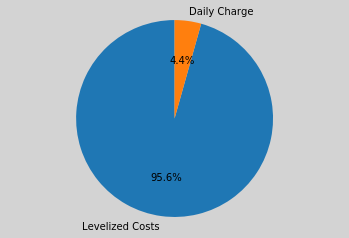

ERROR:ga_logger:panel values: (105.59129148684029, 223.0015310659744, 95.07136280760893, 8.466466589561874, 54.60264682619012, 6.385394687321026, 0.5150582515377862, 0.21584014159089696, 0.87157151436197)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 106
                                           a tilt of 8.5
                                           and a gcr of 0.515


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5856034755706787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 223
                                           a tilt of 54.6
                                           and a gcr of 0.216


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3709895610809326 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 6.4
                                           and a gcr of 0.872


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5302350521087646 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [275.2799104765497, 0.0, 56.040336810870365]


ERROR:ga_logger:Cost: 3423.795377939569


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


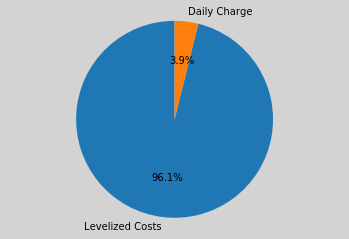

ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


In [28]:
# Bonmin path
BONMIN_PATH = "/home/theochri/projects/def-revins/theochri/Bonmin/bonmin"

# GA
if (opt_method =="ga-20"):
    init_pop=20
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-50"):
    init_pop=50
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-100"):
    init_pop=100
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-net"):
    # implementation of the max_evaluations only works starting from 6 or higher
    # also if you set this max_evalutions to 10 it will stop after 9 evaluations
    # therefore I have added 1 to the max_evaluations. 
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE-NET", bonmin_path=BONMIN_PATH, rand_seed =int(run_i+number_of_opt_evaluations)+10 )
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE", bonmin_path=BONMIN_PATH, rand_seed =int(run_i+number_of_opt_evaluations)+10)
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost-true"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE", bonmin_path=BONMIN_PATH, rand_seed =int(run_i)+10)
    pvoptimizer.processGA(ga_fina)

